Описание кейса:

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.
    
Описание данных:
        
<table >
   <tr>
    <th>Признак</th>
    <th>Описание</th>
  </tr>
  
   <tr>
    <td>hotel_address</td>
    <td>street, post code, city, country </td>
  </tr>
    
   <tr>
    <td>additional_number_of_scoring</td>
    <td>the number of hotel scores without review </td>
  </tr> 
    
  <tr>
    <td>review_date</td>
    <td>the day of review </td>
  </tr>
    
  <tr>
    <td>average_score</td>
    <td>the average rating of the hotel </td>
  </tr>
    
   <tr>
    <td>hotel_name</td>
    <td>the full name of hotel </td>
  </tr>
    
   <tr>
    <td>reviewer_nationality</td>
    <td>country from which the reviewer came </td>
  </tr>
    
   <tr>
    <td>negative_review </td>
    <td>text of negative review </td>
  </tr> 
   
   <tr>
    <td>review_total_negative_word_counts </td>
    <td>the total number words of negative review </td>
  </tr>  
    
   <tr>
    <td>total_number_of_reviews </td>
    <td>the total number of reviews that the hotel has </td>
  </tr>  
    
   <tr>
    <td>positive_review</td>
    <td>text of positive review </td>
  </tr> 
    
   <tr>
    <td>review_total_positive_word_counts</td>
    <td>the total number words of positive review </td>
  </tr> 
    
  <tr>
    <td>total_number_of_reviews_reviewer_has_given</td>
    <td>the total number of reviews reviewer has given </td>
  </tr> 
    
   <tr>
    <td>reviewer_score</td>
    <td>the number of reviewer score </td>
  </tr> 
    
   <tr>
    <td>tags</td>
    <td>tags that describe purpose of trip,type of room, count of nights of reviewer </td>
  </tr> 
    
   <tr>
    <td>days_since_review</td>
    <td>a difference in the number of days between review date and scrape date</td>
  </tr> 
    
   <tr>
    <td>lat</td>
    <td>latitude coordinate of hotel location </td>
  </tr> 
    
   <tr>
    <td>lng</td>
    <td>longitude coordinate of hotel location </td>
  </tr> 
    
</table>
    
</div>


Содержание:

* <a href ="#1">1. Исследование данных</a>
* <a href ="#2">2. Проектирование признаков</a>
  * <a href ="#2.1">2.1 Географическое расположение</a>
  * <a href ="#2.2">2.2 Анализ дат (review_date)</a>
  * <a href ="#2.3">2.3 Анализ тегов (tags)</a>
  * <a href ="#2.4">2.4 Информация о рецензенте</a>
  * <a href ="#2.5">2.5 Обработка отзывов</a>
* <a href ="#3">3. Отбор признаков</a>
* <a href ="#4">4. Обучение моделей и получение предсказаний</a>

In [541]:
%%capture

!pip install Afinn
!pip install nltk[twitter] 
!pip install seaborn 
!pip install plotly.express
!pip install textblob
!pip install -U scikit-learn
!pip install geopy
!pip install catboost

import numpy as np
import os
import re
import random

import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
        
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.downloader.download('vader_lexicon')
nltk.download('movie_reviews')
nltk.download('punkt')

from afinn import Afinn
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif

from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter

from sklearn.ensemble import RandomForestRegressor

from colorama import Fore, Back, Style

In [542]:
RANDOM_STATE = 42
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

In [543]:
# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, заполняем его нулями

# для удобства обьединяем датасеты в один
data = pd.concat([df_train, df_test], ignore_index = True)


<a id = '1'></a>
# 1. Исследование данных

In [544]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Видим, что в данных только 2 признака lat и lng имеют пропуски.

In [545]:
# Сгрупируем по отелям и посмотрим, у каких отелей отсутствуют геоданные
hotels_with_coor = data[data.lng.isna() & data.lat.isna()].groupby(by = ['hotel_address','hotel_name']).\
  count().iloc[:,0].to_frame().reset_index()
hotels_with_coor.head()


,hotel_address,hotel_name,additional_number_of_scoring
0,20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,37
1,23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,55
2,4 rue de la P pini re 8th arr 75008 Paris France,Maison Albar Hotel Paris Op ra Diamond,290
3,Bail n 4 6 Eixample 08010 Barcelona Spain,NH Collection Barcelona Podium,146
4,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,City Hotel Deutschmeister,93


In [546]:
# в итоге у нас 17 отелей, не имеющих геоданные, добавим их вручную

hotels_with_coor[['lat','lng']] = 0
hotels_with_coor.loc[0,['lat','lng']] = ['48.8399957','2.3070823']
hotels_with_coor.loc[1,['lat','lng']] = ['48.8889127','2.3309643']
hotels_with_coor.loc[2,['lat','lng']] = ['48.8753208','2.3212033']
hotels_with_coor.loc[3,['lat','lng']] = ['41.391552','2.1757053']
hotels_with_coor.loc[4,['lat','lng']] = ['48.2208555','16.3644228']
hotels_with_coor.loc[5,['lat','lng']] = ['48.233592','16.3434781']
hotels_with_coor.loc[6,['lat','lng']] = ['48.2094054','16.3512565']
hotels_with_coor.loc[7,['lat','lng']] = ['48.2095525','16.3492746']
hotels_with_coor.loc[8,['lat','lng']] = ['48.1888183','16.381591']
hotels_with_coor.loc[9,['lat','lng']] = ['48.1868142','16.418528']
hotels_with_coor.loc[10,['lat','lng']] = ['41.3749946','2.1102353']
hotels_with_coor.loc[11,['lat','lng']] = ['48.219573','16.2834034']
hotels_with_coor.loc[12,['lat','lng']] = ['41.3832425','2.1607609']
hotels_with_coor.loc[13,['lat','lng']] = ['48.2458909','16.3397395']
hotels_with_coor.loc[14,['lat','lng']] = ['48.2135906','16.3777195']
hotels_with_coor.loc[15,['lat','lng']] = ['48.2168032','16.357717']
hotels_with_coor.loc[16,['lat','lng']] = ['48.220414','16.3536299']

# Так как адрес у нас носит уникальный характер, а название отелей есть повторяющиеся,
# то установим адрес как индекс
hotels_with_coor.set_index('hotel_address', inplace=True)
hotels_with_coor.head()


,hotel_name,additional_number_of_scoring,lat,lng
hotel_address,,,,
20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,37,48.8399957,2.3070823
23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,55,48.8889127,2.3309643
4 rue de la P pini re 8th arr 75008 Paris France,Maison Albar Hotel Paris Op ra Diamond,290,48.8753208,2.3212033
Bail n 4 6 Eixample 08010 Barcelona Spain,NH Collection Barcelona Podium,146,41.391552,2.1757053
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,City Hotel Deutschmeister,93,48.2208555,16.3644228


In [547]:
# функция для заполнения пропусков в геоданных
def add_missing_coors(address, ind_data):
  """
  Входной параметр "адрес" используется для поиска lng, lat в поданном вторым аргументом dataframe.
  Адрес в dataframe является индеком

  Args:
      address (str): строка с адресом отеля
      ind_data (pd.Dataframe()): Dataframe с lng, lat в качестве признаков и адресом в качестве индекса

  Returns:
      pd.Series(): возвращает lng, ltd
  """
  if address in ind_data.index:
    return pd.Series([ind_data.loc[address].lat, ind_data.loc[address].lng],
                     index = ['lat','lng'])

In [548]:
# берем только записи, у которых в наличие пропуски по геоданным, и заполняем пропуски данными в 
# соотвествии с указанными выше геокоординатами
data.loc[data[(data.lat.isna() | data.lng.isna())].index,['lat','lng']] = \
data[data.lat.isna() | data.lng.isna()].loc[:].\
  apply(lambda x: add_missing_coors(x.hotel_address, hotels_with_coor), axis = 1)

Построим графики, чтобы подробно рассмотреть распределение оценок посетителями

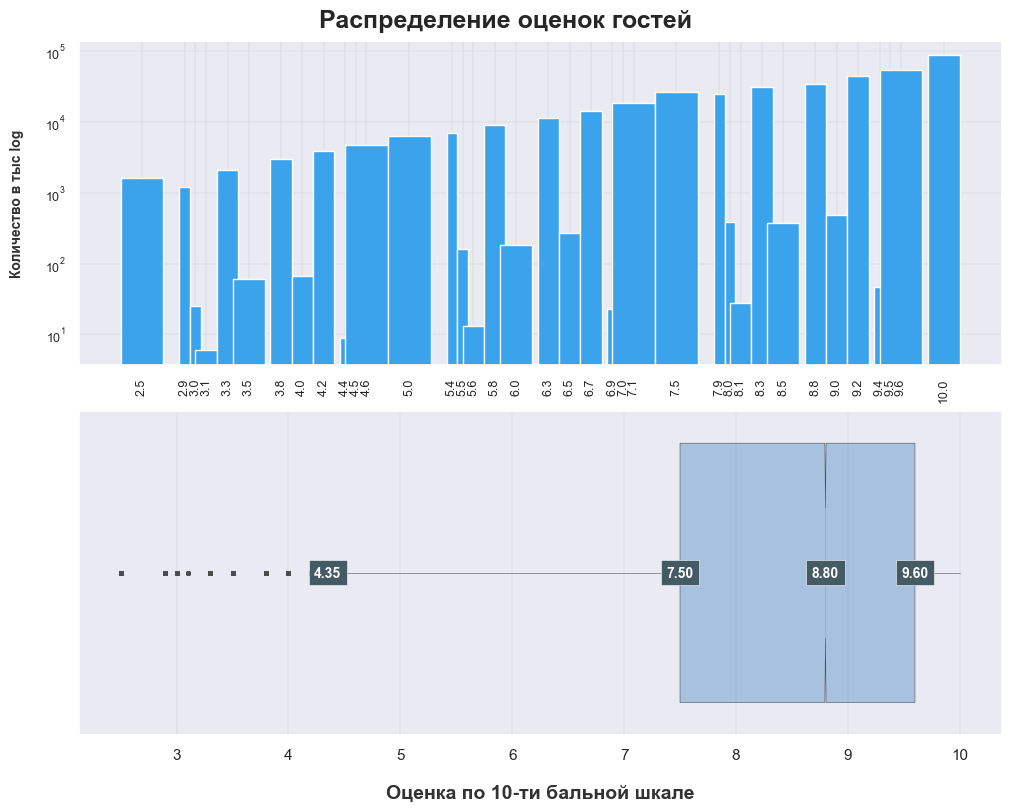

In [549]:
# отобразим на гистограмме ширину столбиков, соответствующую ширине надписей
bins = sorted(np.append(df_train.reviewer_score.unique(),10.3))
# расположим оба графика сразу друг под другом
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True)

# выставим тему и стиль для графиков

sns.set_theme(style="whitegrid", palette="pastel")

rc_style={'patch.edgecolor': 'w',
          'grid.color': '.8',
          'grid.linestyle': "-",
          }
sns.set(rc={"grid.linewidth":.3})
sns.set_style("darkgrid",rc_style)
counts, bins, patches = ax1.hist(data=df_train,
             x="reviewer_score",
             bins=bins, 
             color='#3ba3ec',
             align='left'
            );

sns.boxplot(
    data=df_train, x="reviewer_score",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
    linewidth=.4,
    ax = ax2
);
# для пущей визуализации нанесем значения квантилей, медианы на график, предварительно рассчитав их
q1 = df_train.reviewer_score.quantile([.25]).item()
q3 = df_train.reviewer_score.quantile([.75]).item()
iqr = q3 - q1
text_data = [
    df_train.reviewer_score.median(),
    q1,
    q3,
    q1 - 1.5 * iqr,
]

for t_data in text_data:
    ax2.text(
        # нанесем медианное значение на график
            t_data, 
            0, 
            f'{t_data:.2f}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64',linewidth = .4))

plt.suptitle('Распределение оценок гостей', size = 18, weight = 600)
ax2.set_xlabel('Оценка по 10-ти бальной шкале', fontsize=14, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax1.set_ylabel('Количество в тыс log', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax1.set_xlabel('')
ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_yscale("log")
ax1.tick_params(axis="x", labelrotation=90)
ticks = sorted(set(df_train.reviewer_score));

ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks);

Пришлось прологарифмировать ось ординат, так как оказалось, что у есть оценки с очень маленьким кол-вом отзывов, чтобы их лучше было видно.
Например <span style="color:red">3.1, 3.5, 4.4</span>

Также из boxplot графика, мы видим что медианная оценка 8.8 и основной диапазон выставленных оценок находится между <span style="color:red">7.5 и 9.6</span>

Рассмотрев числовые признаки и график оценок, видим что нет смысла проверять каждый признак на наличие вылетов.

In [550]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,sample
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,0.749999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,0.433014
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,0.250000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,1.000000


Посмотрим не числовые признаки

In [551]:
data[[col for col in data.columns if data[col].dtype == 'O']].head(3)

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,2/19/2016,The May Fair Hotel,United Kingdom,Leaving,Staff were amazing,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,1/12/2017,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,location,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,10/18/2016,Legend Saint Germain by Elegancia,China,No kettle in room,No Positive,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


<a id = '2'></a>
# 2. Проектирование признаков (Feature Engineering)

In [552]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Видим, что можно разбить признаки на логические блоки и изучить по отдельности. <

Это признаки отвечающие за:
* Местоположение обьекта (адрес)
* Дата (временной промежуток выставления оценок)
* Тэги (смысловая текстовая информация об отеле)
* Отзывы и расчетные данные по ним, такие как кол-во слов в отзыве, сколько непроверенных отзывов оставлено и т.п.
* Информация о рецензенте (страна проживания, кол-во отзывов, оставленных данным человеком)

<a id = '2.1'></a>

## 2.1 Географическое расположение (hotel_address)

In [553]:
# выведем 10 рандомных адресов отелей
random_list = random.sample(range(0, data.shape[0]-1), 10)
for idx in random_list:
    display(data.loc[idx]['hotel_address'])


'66 Knightsbridge Westminster Borough London SW1X 7LA United Kingdom'

'Carrer de Arag 271 Eixample 08007 Barcelona Spain'

'Lakeside Way Brent London HA9 0BU United Kingdom'

'Frankenberggasse 10 04 Wieden 1040 Vienna Austria'

'2 Spring Gardens Trafalgar Square Westminster Borough London SW1A 2TS United Kingdom'

'59 Leinster Square Kensington and Chelsea London W2 4PS United Kingdom'

'1 Addington Street Lambeth London SE1 7RY United Kingdom'

'Via della Giustizia 10 D Bicocca Zara 20125 Milan Italy'

'60 Pentonville Road Islington London N1 9LA United Kingdom'

'Via Stamira D Ancona 27 Distretto Viale Monza 20127 Milan Italy'

Признак "Адрес отеля" содержит в себе информацию: 
* Адрес (не обязательно на английском языке)
* Название города
* Индекс

Создадим следующие новые признаки:
* Страна
* Город
* Индекс
* Расстояние от центра города

In [555]:
# Создадим список со всеми отелями и их кординатами
hotels_with_coor = data.groupby(['hotel_address','lat','lng']).count().reset_index().iloc[:,:3].set_index('hotel_address')

# Выделим страну из адресной строки
hotels_with_coor.loc[:,'country'] = \
hotels_with_coor.loc[:].apply(lambda x : 'United Kingdom' if x.name.split()[-1] == 'Kingdom' else x.name.split()[-1], axis = 1)

# Выделим город из адресной строки
hotels_with_coor.loc[:,'city'] = hotels_with_coor.apply(lambda x: ','.join(x.name.split(' ')[-2:-1]), axis = 1)
hotels_with_coor.city = hotels_with_coor.city.apply(lambda x: 'London' if x == 'United' else x)

# Выделим почтовый из адресной строки
hotels_with_coor.loc[:,'post_index'] = \
  hotels_with_coor.apply(lambda x: x.name.strip().split()[-4] if x.country in ('United Kingdom','Netherlands') \
    else x.name.strip().split()[-3], axis = 1)

# Создадим отдельный датасет только одержащий уникальные города из датасета
city_coors = pd.DataFrame(hotels_with_coor.city.unique(), columns=['name'])

# используем библиотеку для работы с геокоординатами
geolocator = Nominatim(user_agent="AV_Kaggle")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Получим координаты центров для представленных в базе городов
city_coors['lat'], city_coors['lng'] = zip(*city_coors.name.apply(lambda x : geolocator.geocode(x)[1]))

# Создадим словарь с индексом название города и данными {lat,lng}
dict_city_locs = city_coors.set_index('name').to_dict('dict')

# Создадим в датафрейме отелей новый признак, координаты центра города, где отель находится
hotels_with_coor['center_lat'] = hotels_with_coor['city'].map(dict_city_locs['lat'])
hotels_with_coor['center_lng'] = hotels_with_coor['city'].map(dict_city_locs['lng'])

# расчитаем расстояние по прямой от координат отеля до центра города
hotels_with_coor['distance_from_center'] = hotels_with_coor.apply(lambda x :\
  geodesic((x.lat,x.lng),(x.center_lat, x.center_lng)).kilometers, axis = 1)

# Создадим новый словарь с полученнми ранее данными
dict_hotel_extra = hotels_with_coor[['country','city','distance_from_center','post_index']].\
  to_dict('dict')

# Создадим новые признаки в основном датафрейме
data['city'] = data.hotel_address.map(dict_hotel_extra['city'])
data['country'] = data.hotel_address.map(dict_hotel_extra['country'])
data['post_index'] = data.hotel_address.map(dict_hotel_extra['post_index'])
data['distance_from_center'] = data.hotel_address.map(dict_hotel_extra['distance_from_center'])

print('Уникальных стран:', ', '.join(hotels_with_coor.country.unique()), '\n')
print('Уникальных городов:', ', '.join(city_coors.name.values), '\n')
for key, item in hotels_with_coor.groupby(by=['city']).post_index.apply(list).to_dict().items():
  print('Город:', key)
  print('Районы', ', '.join(sorted(set(item))))


Уникальных стран: Netherlands, United Kingdom, France, Spain, Italy, Austria 

Уникальных городов: Amsterdam, London, Paris, Barcelona, Milan, Vienna 

Город: Amsterdam
Районы 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1031, 1033, 1043, 1052, 1053, 1054, 1055, 1057, 1058, 1062, 1064, 1066, 1067, 1071, 1072, 1075, 1077, 1082, 1083, 1087, 1091, 1092, 1093, 1096, 1097, 1101, 1105, 1108
Город: Barcelona
Районы 08001, 08002, 08003, 08004, 08005, 08006, 08007, 08008, 08009, 08010, 08011, 08012, 08013, 08014, 08015, 08017, 08018, 08019, 08021, 08022, 08023, 08025, 08026, 08028, 08029, 08034, 08035, 08036, 08037, 08038, 08039, 08040, 08950
Город: London
Районы E1, E14, E15, E16, E1W, E2, E20, E8, EC1M, EC1R, EC1V, EC1Y, EC2A, EC2M, EC2R, EC3A, EC3N, EC3V, EC4M, EC4V, EC4Y, HA9, IG8, N1, N1C, N4, NW1, NW2, NW3, NW4, NW6, NW8, SE1, SE10, SE11, SE16, SW10, SW11, SW14, SW15, SW19, SW1A, SW1E, SW1H, SW1P, SW1V, SW1W, SW1X, SW1Y, SW3, SW5, SW6, SW7, SW8, W10, W11, W12, W13, W14, W1B, W1C,

Сравним оценки для разных городов (в каждой стране рассмотрены только отели из одного города).

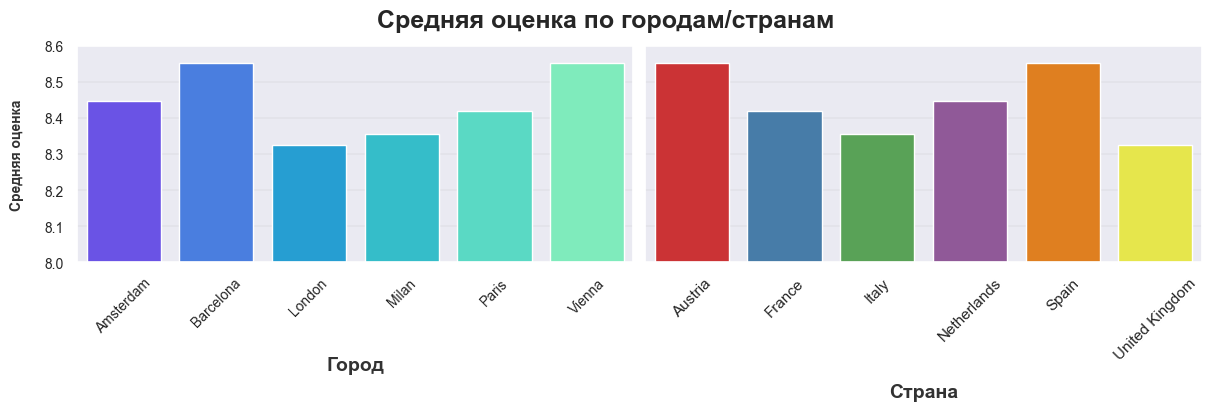

In [556]:
# для удобства понимания, расположим оба графика бок о бок

cities = pd.pivot_table(
    data=data[data['sample']==1],
    index='city', 
    values='reviewer_score', 
    aggfunc=['mean'])

countries = pd.pivot_table(
    data=data[data['sample']==1],
    index='country', 
    values='reviewer_score', 
    aggfunc=['mean'])

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True, sharey=True)


sns.set(rc={"grid.linewidth":.3})
sns.set_style("darkgrid",rc_style)

ax1.set_ylim(8, 8.6);

pal1 = sns.color_palette("rainbow", 12)
sns.set_palette(pal1)

sns.barplot(x=cities.index, y=cities[('mean', 'reviewer_score')], ax=ax1);

pal2 = sns.color_palette("Set1", 12)
sns.set_palette(pal2)

sns.barplot(x=countries.index, y=countries[('mean', 'reviewer_score')], ax=ax2);
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Средняя оценка', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax1.set_xlabel('Город', fontsize=14, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax2.set_xlabel('Страна', fontsize=14, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax1.tick_params(axis='both', which='major', labelsize=10)

plt.suptitle('Средняя оценка по городам/странам', size = 18, weight = 600)
ax2.set_ylabel('');



Зависимость средней оценки отеля от расстояния от центра города

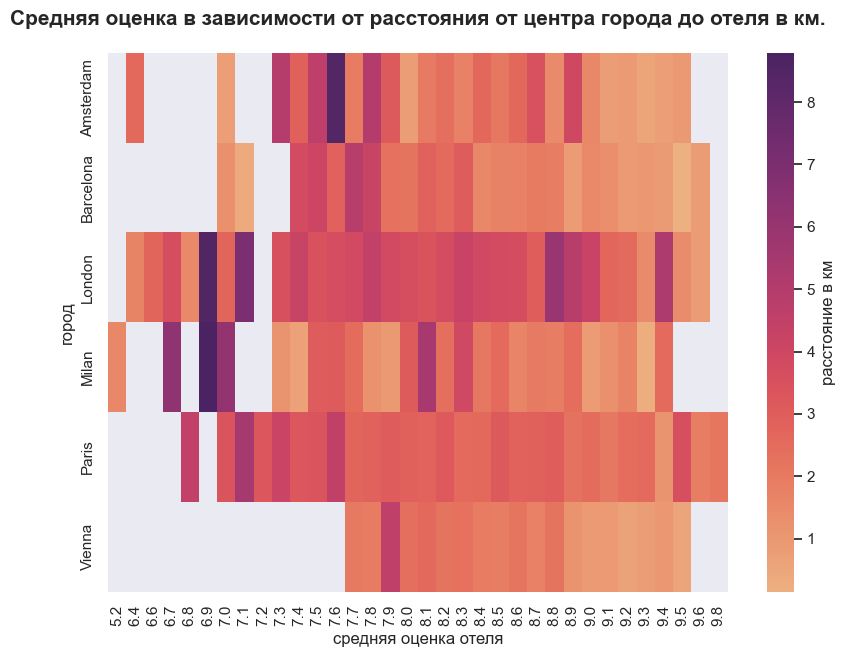

In [557]:
pivot_distance = data[data['sample']==1].pivot_table(
    values='distance_from_center',
    columns='average_score',
    index='city')
pivot_distance.columns = pivot_distance.columns.astype('string')
fig, ax = plt.subplots(figsize=(10,7))    
heatmap = sns.heatmap(data=pivot_distance, cmap='flare', 
                      cbar_kws={'label': 'расстояние в км'})
heatmap.set_title('Средняя оценка в зависимости от расстояния от центра города до отеля в км.',
                  fontsize=15, fontweight='bold', pad=20);
heatmap.set_xlabel('средняя оценка отеля');
heatmap.set_ylabel('город');

<a id = '2.2'></a>
## 2.2 Анализ дат (review_date)

In [558]:
# Создадим новые признаки из даты: год, месяц, день
data['review_date'] = pd.to_datetime(data['review_date'])
data['month']=pd.to_datetime(data['review_date']).dt.month
data['year']=pd.to_datetime(data['review_date']).dt.year
data['day']=pd.to_datetime(data['review_date']).dt.day


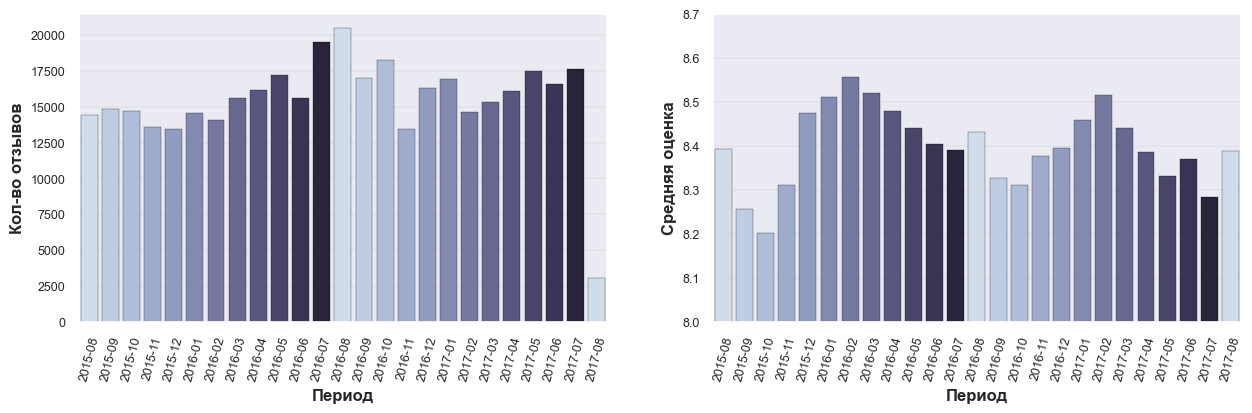

In [559]:
# Создадим еще один признак из даты, год и месяц в одном лице
data['review_period'] = data['review_date'].dt.to_period("M")

# Соберем данные для визулизации
period = data[data['sample']==1].pivot_table(
    values='reviewer_score',
    index='review_period',
    aggfunc=['mean', 'count']
)

rc_style={'patch.edgecolor': 'black',
          'grid.color': '.8',
          'grid.linestyle': "-",
          }
sns.set_style("darkgrid",rc_style)

clr = sns.color_palette("ch:s=.15,rot=-.15",12)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x=period.index, y=period[('count', 'reviewer_score')], ax=ax1, palette=clr, linewidth=.2);

ax1.set_ylabel('Кол-во отзывов', fontweight = 600, fontsize = 12);

ax1.tick_params(axis='x', rotation=75)

sns.barplot(x=period.index, y=period[('mean', 'reviewer_score')], ax=ax2, palette=clr, linewidth=.2);
ax2.set_ylabel('Средняя оценка', fontweight = 600, fontsize = 12);
ax2.tick_params(axis='x', rotation=75)

ax1.set_xlabel('Период', fontweight = 600, fontsize = 12);
ax2.set_xlabel('Период', fontweight = 600, fontsize = 12);

ax1.tick_params(axis='both', which='major', labelsize=9)
ax2.tick_params(axis='both', which='major', labelsize=9)

plt.ylim(8, 8.7)
plt.show()

Наблюдается цикличность, т.е каждый определенный месяц нового года ситуация схожа с аналогичным периодом предыдущего года. 

<a id = '2.3'></a>
## 2.3 Анализ тегов (tags)

In [560]:
# рассмотрим подробнее столбец "тэги"
tags = set()
tags_list = list()
for index, value in data['tags'].items():
        pre_tags = value
        pre_tags = pre_tags.replace('[', '').replace(']', '')
        pre_tags = pre_tags.replace("'", '')
        pre_tags = pre_tags.split(",")
        for i in pre_tags:
            tags.add(i.strip())
            tags_list.append(i.strip())

print("Уникальное количество тэгов:", len(tags))
print("Всего тэгов:", len(tags_list))   

Уникальное количество тэгов: 2428
Всего тэгов: 2356592


In [561]:
# посмотрим на самые популярные тэги
tags_series = pd.Series(
    data = tags_list,
    index = tags_list,
    name = 'tags_series'
)
print("Top 20 популярных тэгов:\n")
print(tags_series.value_counts()[:30]) 

Top 20 популярных тэгов:

tags_series
Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Deluxe Double Room                 24823
Double or Twin Room                22393
Stayed 5 nights                    20845
Standard Double or Twin Room       17483
Classic Double Room                16989
Superior Double or Twin Room       13570
2 rooms                            12393
Stayed 6 nights                     9776
Standard Twin Room 

Тэги содержат разный тип информации:
* количество проведенных дней
* в какой группе путешествовал человек
* тип номера
* был ли отель забронирован с мобильного девайса

Проверим, одинаковое ли кол-во тэгов у каждой записи:

In [562]:
data['temp_tag_count'] = data.tags.apply(lambda x : x[2:-2].split(',').__len__())

In [563]:
data.temp_tag_count.value_counts()

temp_tag_count
5    297823
4    211564
3      5505
6       755
2        85
1         6
Name: count, dtype: int64

К сожалению, у разных отзывов может быть любое количество тэгов.

Попробуем выделить следующие признаки:
* тип поездки
* был ли отель забронирован с мобильного девайса
* в какой компании путешествовали 
* было ли окно в номере
* тип комнаты
* продолжительность пребывания в отеле

In [564]:
rule_type = ['Leisure trip','Business trip']
rule_submit = ['Submitted from a mobile device']
rule_travellers = ['Couple','Solo traveler','Group','Travelers with friends','Family with older children','Family with young children']
rule_with_pet = ['With a pet']

def extract_data(row, feature_name, rules):
  """Функция, которая для указанного признака возвращает тэг согласно 
  установленным выше правилам

  Args:
      row (str): Строка содержащая tag
      feature_name (str): название признака
      rules (list): правило

  Returns:
      int/str/np.nan: В зависимости от правил, возвращает значение для признака
  """
  if feature_name == 'trip_type':
    for rule in rules:
      if rule in row:
        return rule
    else:
      return np.nan
  if feature_name == 'sumbit_type':
    for rule in rules:
      if rule in row:
        return 1
    else:
      return 0
  if feature_name == 'travellers_type':
    for rule in rules:
      if rule in row:
        if rule in ['Group', 'Travelers with friends']:
          return 'Group'
        elif rule == 'Couple':
          return 'Couple'
        elif rule == 'Solo traveler':
          return 'Solo'
        elif rule == 'Family with older children':
          return 'Family with older children'
        elif rule == 'Family with young children':
          return 'Family with young children'        
    else:
      return np.nan    
  if feature_name == 'with_pet_type':
    for rule in rules:
      if rule in row:
        return 1
    else:
      return 0
  if feature_name == 'with_view':
    if re.search(r'with.+view|panoram|observatory', row, flags=re.IGNORECASE):
        return 1
    else:
      return 0    
  if feature_name == 'without_window':
    if re.search(r'without.+window', row, flags=re.IGNORECASE):
        return 1
    else:
      return 0       

data['trip_type'] = data.tags.apply(lambda x : extract_data(x,'trip_type',rule_type))
data['sumbit_type'] = data.tags.apply(lambda x : extract_data(x,'sumbit_type',rule_submit))
data['travellers_type'] = data.tags.apply(lambda x : extract_data(x,'travellers_type',rule_travellers))
data['with_pet_type'] = data.tags.apply(lambda x : extract_data(x,'with_pet_type',rule_with_pet))
data['with_view'] = data.tags.apply(lambda x : extract_data(x,'with_view',[]))
data['without_window'] = data.tags.apply(lambda x : extract_data(x,'without_window',[]))
 

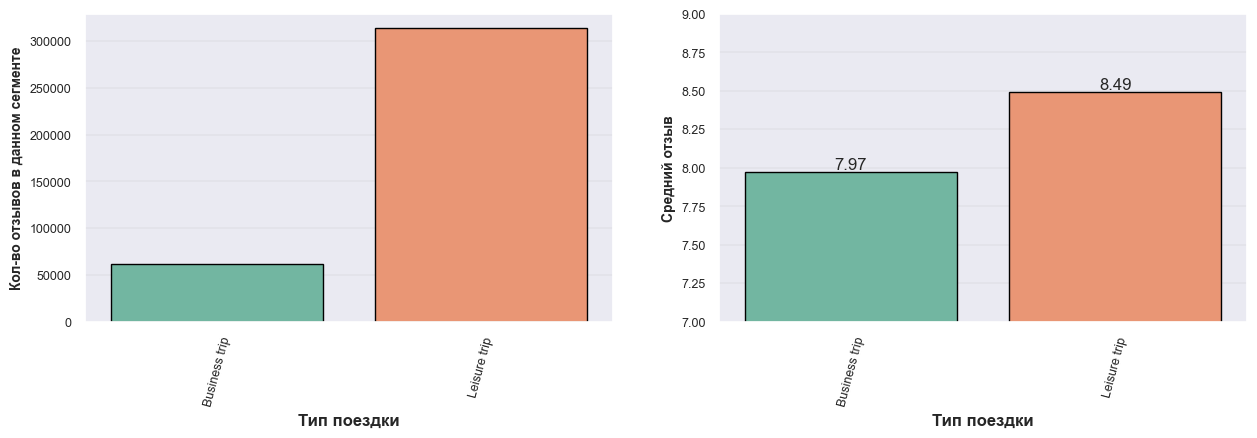

In [565]:
# строим график соотношения типа поездки и отзывов 
travel_type = pd.pivot_table(
    data=data[data['sample'] == 1],
    index='trip_type', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])

xticklabels_guest = ["Business trip", "Leisure trip"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), linewidth = .4)

pal2 = sns.color_palette("Set2", 12)
sns.set_palette(pal2)

sns.barplot(x=travel_type.index, y=travel_type[('count', 'reviewer_score')], ax=ax1);
ax1.set_xticklabels(xticklabels_guest, fontsize = 10, rotation = 75)
ax1.set_ylabel('Кол-во отзывов в данном сегменте', fontweight='bold', fontsize=10)

bar_rooms = sns.barplot(x=travel_type.index, y=travel_type[('mean', 'reviewer_score')], ax=ax2);
ax2.set_ylabel('Средний отзыв', fontweight='bold', fontsize=10)
ax2.set_xticklabels(xticklabels_guest, fontsize = 10,  rotation = 75)

for p in bar_rooms.patches:
    bar_rooms.annotate(
    '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=12)

ax1.set_xlabel('Тип поездки', fontweight = 600, fontsize = 12);
ax2.set_xlabel('Тип поездки', fontweight = 600, fontsize = 12);

ax1.tick_params(axis='both', which='major', labelsize=9)
ax2.tick_params(axis='both', which='major', labelsize=9)

plt.ylim(7, 9);
plt.show()

In [566]:
# У нас есть пропуски в поле trip_type, заполним модой
data.loc[data[data.trip_type.isna()].index,'trip_type'] = data.trip_type.mode().item()

Основные посетители - это путешествующие люди, а не бизнес-поездки. И разница в средних оценках существует. Люди по бизнесу менее счастивы от посещения отелей.

In [567]:
# Функция убирающая пробелы, аппострофы в строке тэгов, и приводящая строку к списку тэгов
def tagsToList(value):
  val = re.sub(r"\s'\s|\s\'", '',value[2:-2].strip()).split(',') 
  return val

tags_temp_df = data.tags.apply(tagsToList).to_frame()

tags = np.unique(np.hstack(tags_temp_df['tags'])).tolist()
tags_df = pd.DataFrame(tags, columns=['tag'])

In [568]:
def tags_remove_from_list(tag_set_full, tag_set_diff):
  """Опираясь на правила в regular expressions, выявляем классы комнат из датасета, содержащего все тэги.
  После вычленения очередных тэгов, возвращаем датасет тэгов с удаленными записями вычлененных на
  данном шаге тэгов

  Args:
      tag_set_full (pandas.Dataframe): начальный датасет
      tag_set_diff (pandas.Dataframe): датасет, значения которого надо вычесть из начального датасета

  Returns:
      pandas.Dataframe: Результирующий датасет
  """
  return pd.DataFrame(set(tag_set_full.tag).difference(set(tag_set_diff.tag)),columns=['tag'])

tags_df = tags_remove_from_list(tags_df,pd.DataFrame((rule_type + rule_submit + rule_travellers + rule_with_pet), columns=['tag']))

# правила для разделения отзывово по типам комнат
room_type_deluxe_with_view = tags_df[tags_df.tag.str.contains('deluxe', regex=True, case=False)]
tags_df = tags_remove_from_list(tags_df,room_type_deluxe_with_view)
room_type_economy = tags_df[tags_df.tag.str.contains('economy|^small|mini.+room|compact|basic', regex=True, case=False)]
tags_df = tags_remove_from_list(tags_df,room_type_economy)
room_type_standard = tags_df[tags_df.tag.str.contains('standard|classic', regex=True, case=False)]
tags_df = tags_remove_from_list(tags_df,room_type_standard)
room_type_apartment = tags_df[tags_df.tag.str.contains('Apartement|Apartment', regex=True, case=False)]
tags_df = tags_remove_from_list(tags_df,room_type_apartment)
room_type_business = tags_df[tags_df.tag.str.contains('Business', regex=True, case=False)]
tags_df = tags_remove_from_list(tags_df,room_type_business)
room_type_executive = tags_df[tags_df.tag.str.contains('executive', regex=True, case=False)]
tags_df = tags_remove_from_list(tags_df,room_type_executive)
room_type_premier = tags_df[tags_df.tag.str.contains('premier|privilege|premium|prestige|president', regex=True, case=False)]
tags_df = tags_remove_from_list(tags_df,room_type_premier)
room_type_comfort = tags_df[tags_df.tag.str.contains('comfort|superior|deluxe|luxury|large|cosy|romantic|royal|cozy|confort|exclusive|fabulous|special|sensation|wonderful|emotion|club|art', regex=True, case=False)]
tags_df = tags_remove_from_list(tags_df,room_type_comfort)

# создаем словарь тэгов, где индекс - класс комнаты, значения - список тэгов, попадающих под это определение
room_classes = {'standard' : set(room_type_standard.tag), 'apartament' : set(room_type_apartment.tag), 'business' : set(room_type_business.tag),\
  'executive' : set(room_type_executive.tag), 'premier' : set(room_type_premier.tag), 'comfort' : set(room_type_comfort.tag)}

def get_room_class(tag):
  """Определяем, к какому классу комнаты относится запись в поле тэг

  Args:
      tag (str): значение тэга

  Returns:
      str: класс комнаты
  """
  for idx, room_class in room_classes.items():
    for r_class in room_class:
      if r_class in tag:
        return idx
  return 'standard'

data['room_class'] = data.tags.apply(get_room_class)

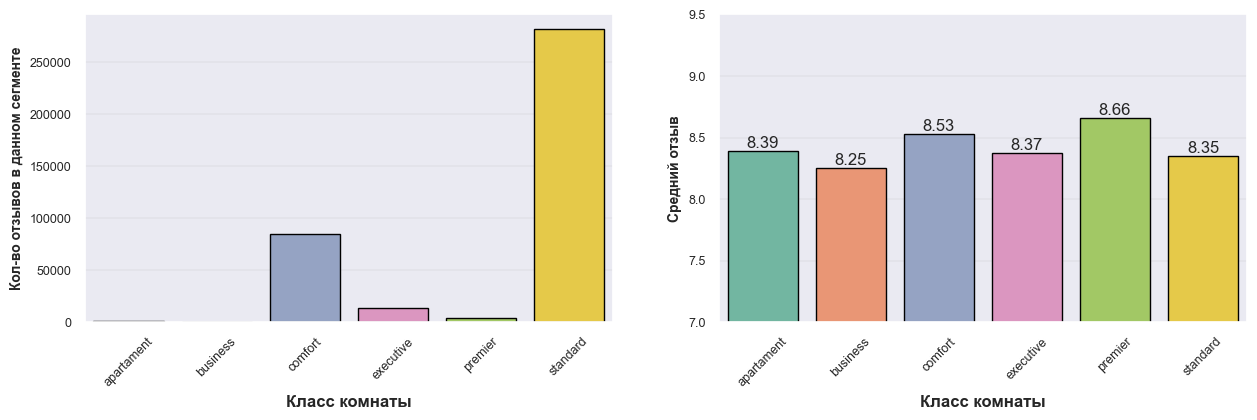

In [569]:
# строим график для 'room_class'

room_class= pd.pivot_table(
    data=data[data['sample']==1],
    index='room_class', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), linewidth = .4)
sns.barplot(x=room_class.index, y=room_class[('count', 'reviewer_score')], ax=ax1);
ax1.set_ylabel('Кол-во отзывов в данном сегменте', fontweight ='bold', fontsize = 10)
ax1.tick_params(axis='x', rotation=45)

bar_rooms = sns.barplot(x=room_class.index, y=room_class[('mean', 'reviewer_score')], ax=ax2);
ax2.set_ylabel('Средний отзыв', fontweight ='bold', fontsize = 10)
ax2.tick_params(axis='x', rotation=45)
plt.ylim(7, 9.5);

for p in bar_rooms.patches:
    bar_rooms.annotate(
    '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=12)

ax1.set_xlabel('Класс комнаты', fontweight = 600, fontsize = 12);
ax2.set_xlabel('Класс комнаты', fontweight = 600, fontsize = 12);

ax1.tick_params(axis='both', which='major', labelsize=9)
ax2.tick_params(axis='both', which='major', labelsize=9)
    
plt.show()

Из данного графика мы видим красивую картину справа, данные разнятся, а вот слева все упирается в кол-во отзывов, а они практически все в одном сегменте - Standard. 

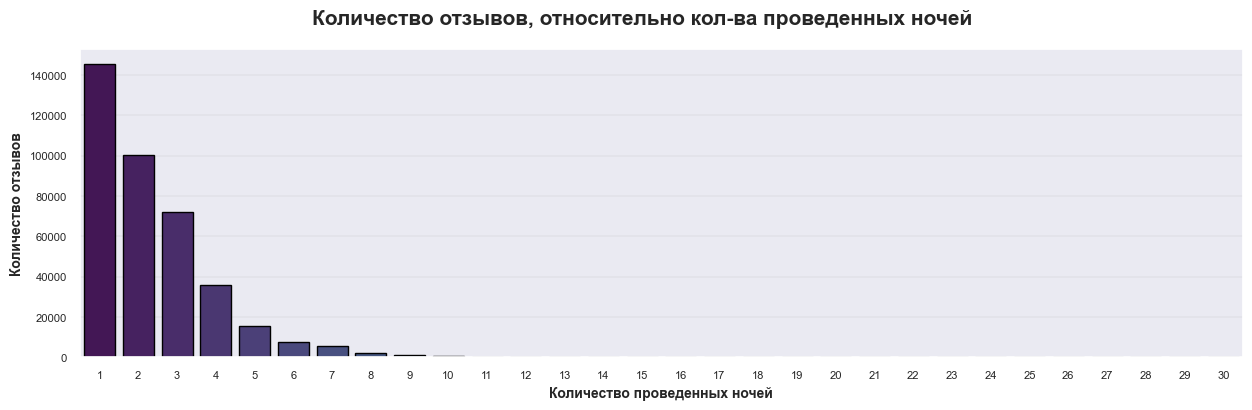

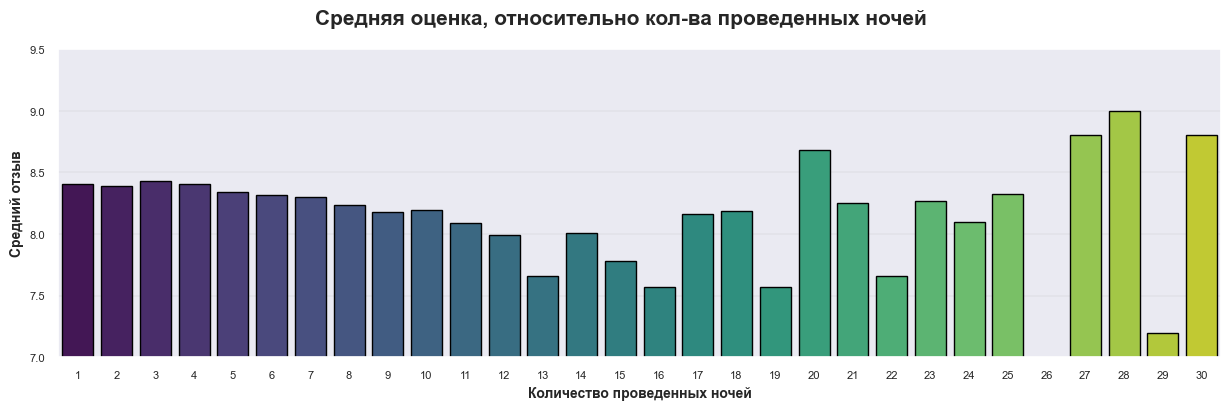

In [570]:
def extract_number_nights(tags):
    """Получаем кол-во дней проведенных постояльцем из записи Tags
    Args:
        tags (str): строка tags
    Returns:
        int : Количество дней
    """ 
    express = re.findall(r'Stayed\s([0-9]+)\snight', tags)
    for elem, num in enumerate(express):
        return np.int8(num)

# получаем новый признак "количество проведенных ночей"
data['count_nights'] = data['tags'].apply(extract_number_nights)
# там, где не указана продолжительность остановки, заполняем модой
mode_night = data['count_nights'].mode()[0]
data['count_nights'] = data['count_nights'].fillna(mode_night)
data['count_nights'] = data['count_nights'].astype('int8')

# строим график
pivot_nights = pd.pivot_table(
    data=data[data['sample']==1],
    index='count_nights', 
    values='reviewer_score', 
    aggfunc=['count', 'mean']
)

fig, ax = plt.subplots(figsize=(15, 4))
clr = sns.color_palette("viridis",31)
plt.suptitle('Количество отзывов, относительно кол-ва проведенных ночей', 
             fontweight ='bold', size=15)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')], palette=clr)
plt.xlabel('Количество проведенных ночей', 
           fontweight ='bold', fontsize = 10)
plt.ylabel('Количество отзывов', fontweight ='bold', fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=8)

fig1, ax1 = plt.subplots(figsize=(15, 4))
plt.suptitle('Средняя оценка, относительно кол-ва проведенных ночей', 
             fontweight ='bold', size=15)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('mean', 'reviewer_score')],palette=clr)
plt.xlabel('Количество проведенных ночей', 
           fontweight ='bold', fontsize = 10)
plt.ylabel('Средний отзыв', fontweight ='bold', fontsize = 10)
plt.ylim(7, 9.5)
ax1.tick_params(axis='both', which='major', labelsize=8)


plt.show()


In [571]:
# всё, что больше или равно 7-ми ночей, приравняем к 7
data.count_nights = data.count_nights.apply(lambda x: 7 if x >= 7 else x)

In [572]:
# создадим отдельный признак по каждому из самых популярных тэгов, вдобавок к ранее полученным признакам
tags_series.value_counts()[:10]

tags_series
Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Name: count, dtype: int64

In [573]:
tags_df = pd.DataFrame(set(tags_series.value_counts()[:10].index), columns = ['tags'])

In [574]:
for tag in set(tags_df.tags):
    tag_name = str(tag)
    data[tag_name] =  data['tags'].apply(lambda x: 1 if tag_name in x else 0)

In [575]:
# Создадим временный датасет, чтобы подсчитать среднюю оценку рецензента и кол-во оценок в данном тэге
top_tags_info = pd.concat([data[data['sample']==1].iloc[:,37:],data[data['sample']==1].loc[:,'reviewer_score']], axis = 1)

top_tags_info_df = pd.DataFrame()

for col in top_tags_info.columns[:-1]:
  
  ser = pd.DataFrame(data = {
      'count': top_tags_info[top_tags_info.loc[:,col] == 1].reviewer_score.count(),
      'mean' : top_tags_info[top_tags_info.loc[:,col] == 1].reviewer_score.mean(),
    }, index = [col])
  top_tags_info_df = \
  pd.concat([
    ser,
    top_tags_info_df,
  ],
  axis = 0,
)

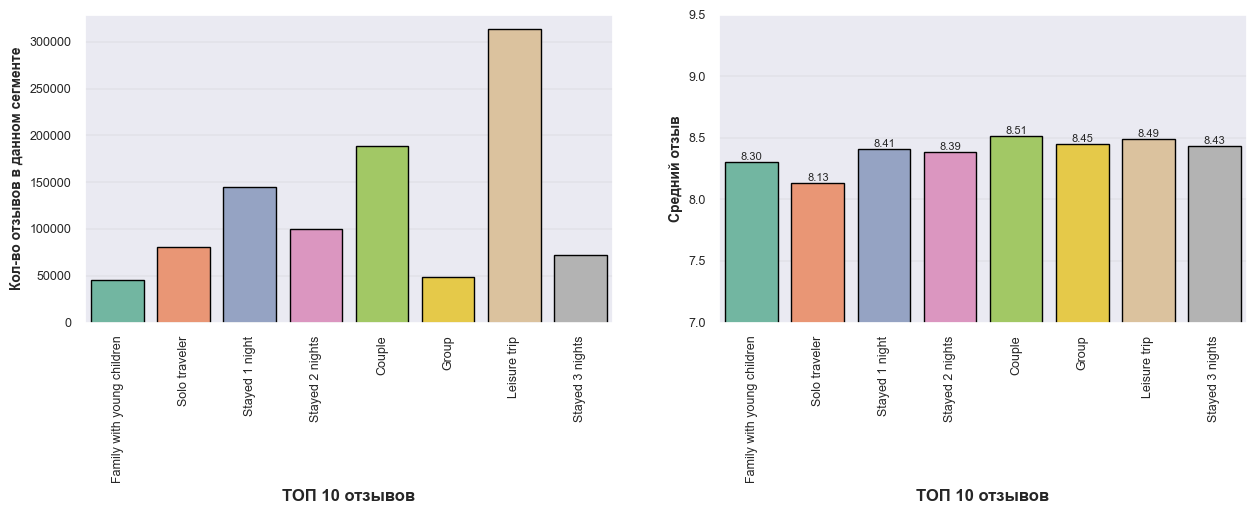

In [576]:
# Визуализируем ТОП 10 тэгов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), linewidth = .4)
sns.barplot(x=top_tags_info_df.index, y=top_tags_info_df[('count')], ax=ax1);
ax1.set_ylabel('Кол-во отзывов в данном сегменте', fontweight ='bold', fontsize = 10)
ax1.tick_params(axis='x', rotation=90)

bar_rooms = sns.barplot(x=top_tags_info_df.index, y=top_tags_info_df[('mean')], ax=ax2);
ax2.set_ylabel('Средний отзыв', fontweight ='bold', fontsize = 10)
ax2.tick_params(axis='x', rotation=90)
plt.ylim(7, 9.5);

for p in bar_rooms.patches:
    bar_rooms.annotate(
    '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('ТОП 10 отзывов', fontweight = 600, fontsize = 12);
ax2.set_xlabel('ТОП 10 отзывов', fontweight = 600, fontsize = 12);

ax1.tick_params(axis='both', which='major', labelsize=9)
ax2.tick_params(axis='both', which='major', labelsize=9)
    
plt.show()

<a id = '2.4'></a>
## 2.4 Информация о рецензенте

In [577]:
# рассмотрим теперь признак reviewer_nationality
data.reviewer_nationality.value_counts()

reviewer_nationality
 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Guinea                            1
 Tuvalu                            1
 Comoros                           1
 Anguilla                          1
 Cape Verde                        1
Name: count, Length: 227, dtype: int64

Есть страны с 1 отзывом, и есть Великобритания, на которую на одну приходится около 60% всех отзывов.

Страны в ТОП оставим как есть, а остальные обьединим по регионам, чтобы осталась принадлежность к определенной части ареала обитания. Возможно, от уровня специфики страны, региона, может изменяться оценка постояльцем.

In [578]:
# Null записей нету, но проверим на всякий случай, нет ли пустых записей
cnt_no_nationality = data[data.reviewer_nationality.str.strip() == ''].shape[0]
print("Количество записей без указанной национальности reviewer-а:",cnt_no_nationality)


Количество записей без указанной национальности reviewer-а: 523


In [579]:
# заполним модой
mode_country_reviewer = data.reviewer_nationality.mode().item()
data.loc[data[data.reviewer_nationality.str.strip() == ''].index,'reviewer_nationality'] = mode_country_reviewer

# уберем пробелы в столбце "национальность рецензента"
data.reviewer_nationality = data.reviewer_nationality.map(str.strip)

In [580]:
# пусть в топ входят только страны, у которых количество отзывов >40 (это 122 страны)
countries_top = data['reviewer_nationality'].value_counts().nlargest(122)
countries_top.index = countries_top.index.map(str.strip)
countries_top = countries_top.to_frame()
countries_top

,count
reviewer_nationality,
United Kingdom,245769
United States of America,35437
Australia,21686
Ireland,14827
United Arab Emirates,10235
...,...
Zimbabwe,51
Sudan,51
Maldives,49


In [581]:
# Отдельно выделяем страны, не вошедшие в топ 122
countries_bottom = data['reviewer_nationality'].value_counts().nsmallest(data['reviewer_nationality'].\
  value_counts().shape[0] - 121).\
  to_frame().rename(columns = {'reviewer_nationality': 'sub_region'})
countries_bottom.index = countries_bottom.index.map(str.strip)

# Отдельно скачан с kaggle файл, содержащий информацию по регионам
regions = pd.read_csv('data/country_regions.csv')
regions = regions[["name", "sub-region"]].dropna()
regions = regions.set_index('name').to_dict()

# обновляем информацию из загруженного датасета
countries_bottom['sub_region'] = countries_bottom.index.map(regions['sub-region'])

In [582]:
countries_bottom

,count,sub_region
reviewer_nationality,,
Anguilla,1,Latin America and the Caribbean
Svalbard Jan Mayen,1,NaN
Guinea,1,Sub-Saharan Africa
Northern Mariana Islands,1,Micronesia
Comoros,1,Sub-Saharan Africa
...,...,...
Mongolia,39,Eastern Asia
Cura ao,41,NaN
Jamaica,41,Latin America and the Caribbean


In [583]:
countries_bottom[countries_bottom['sub_region'].isna() == True]

,count,sub_region
reviewer_nationality,,
Svalbard Jan Mayen,1,NaN
Vatican City,1,NaN
Cape Verde,1,NaN
St Pierre and Miquelon,2,NaN
Cocos K I,2,NaN
Saint Vincent Grenadines,2,NaN
Saint Barts,3,NaN
Central Africa Republic,3,NaN
Bonaire St Eustatius and Saba,3,NaN


In [584]:
# Создаем словарь с соответствиями названий стран
countries_dict = {
  'Ivory Coast': 'Western Africa',
  'Svalbard Jan Mayen':'Northern Europe',
  'Vatican City':'Southern Europe',
  'Cape Verde':'Western Africa',
  'Cocos K I':'Australia and New Zealand',
  'St Pierre and Miquelon':'Northern America',
  'Cura ao':'Latin America and the Caribbean',
  'Syria':'Western Asia',
  'Bolivia':'Latin America and the Caribbean',
  'British Virgin Islands':'Latin America and the Caribbean',
  'U S Virgin Islands':'Latin America and the Caribbean',
  'Antigua Barbuda':'Latin America and the Caribbean',
  'Turks Caicos Islands':'Latin America and the Caribbean',
  'St Maarten':'Latin America and the Caribbean',  
  'Antarctica':'Antarctica',
  'Saint Barts':'Latin America and the Caribbean',
  'Saint Vincent Grenadines':'Latin America and the Caribbean',
  'Bonaire St Eustatius and Saba':'Latin America and the Caribbean',  
  'Central Africa Republic':'Middle Africa',
  'East Timor':'South-eastern Asia',
  'Saint Martin':'Latin America and the Caribbean',   
  'Falkland Islands Malvinas':'Latin America and the Caribbean',  
  'Reunion':'Eastern Africa',
  'Crimea' : 'Russia',
  'Swaziland':'Southern Africa',
  'Democratic Republic of the Congo':'Middle Africa',
  'Laos':'South-eastern Asia',
  'Cayman Islands' : 'Latin America and the Caribbean',
  
}

In [585]:
# формируем признак sub_region
countries_top['sub_region'] = countries_top.index.map(lambda x : x.strip())
countries_bottom.loc[countries_bottom[countries_bottom.sub_region.isna()].index,'sub_region'] = countries_bottom.\
  loc[countries_bottom[countries_bottom.sub_region.isna()].index,'sub_region'].index.map(countries_dict)
# обьединяем в один датасет все страны
countries_list = pd.concat([countries_top, countries_bottom])

In [586]:
# ТОП страны сохранили названия своей страны
countries_list.head(3)

,count,sub_region
reviewer_nationality,,
United Kingdom,245769,United Kingdom
United States of America,35437,United States of America
Australia,21686,Australia


In [587]:
# Не ТОП, получили название региона
countries_list.tail(3)

,count,sub_region
reviewer_nationality,,
Jamaica,41,Latin America and the Caribbean
Botswana,42,Sub-Saharan Africa
Cayman Islands,42,Latin America and the Caribbean


In [588]:
# загрузим из стороннего источника информацию по официальным языкам
languages = pd.read_html('https://www.everycountryintheworld.com/languages/')
languages = languages[0].set_index('Country')
languages.head(5)

,Official Language
Country,
Afghanistan,"Pashto, Dari"
Albania,Albanian
Algeria,"Arabic, Tamazight"
Andorra,Catalan
Angola,Portuguese


In [589]:
languages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, Afghanistan to Zimbabwe
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Official Language  193 non-null    object
dtypes: object(1)
memory usage: 3.0+ KB


In [590]:
# сформируем список из представленных стран в датасете и выставим основной язык в этой стране

hotels_countries = data.country.value_counts().to_frame()
hotels_countries['language'] = hotels_countries.index.map(languages['Official Language'].map(lambda x: x.split(' ')[0].replace(',', '')).to_dict())
hotels_countries_dict = hotels_countries.to_dict()['language']

hotels_countries

,count,language
country,,
United Kingdom,262301,English
Spain,60149,Spanish
France,59928,French
Netherlands,57214,Dutch
Austria,38939,German
Italy,37207,Italian


In [591]:
# приведем датафрейм к словарю
lang_dict = languages['Official Language'].to_dict()

# добавляем недостающие 
add_lang_dict = {'Hong Kong': 'Mandarin Chinese, English',
'Jersey': 'Jèrriais, French, English',
'Gibraltar': 'English',
'Isle of Man': 'Manx, English',
'South Korea': 'Korean',
'Puerto Rico': 'Spanish, English',
'Guernsey': 'English',
'Bermuda': 'English',
'Taiwan': 'Mandarin Chinese',
'Macedonia': 'Macedonian, Albanian',
'Kosovo': 'Albanian, Serbian',
'Abkhazia Georgia':'Abkhaz, Russian, Georgian',
'United States Minor Outlying Islands': 'English',
'Faroe Islands': 'Faroese',
'Macau': 'Chinese, Portuguese',
'Cayman Islands': 'English',
'Cura ao': 'Papiamento, Dutch, English',
'U S Virgin Islands': 'English',
'Antarctica': 'English',
'Aruba': 'Papiamento, Dutch',
'Palestinian Territory': 'Arabic',
'French Polynesia': 'French',
'Anguilla': 'English',
'Falkland Islands Malvinas': 'English',
'Turks Caicos Islands': 'English',
'Cook Islands': 'English, Cook Islands Māori (including Pukapukan[a])',
'Crimea': 'Russian, Ukranian, Crimean Tatar',
'St Maarten': 'Dutch, English',
'British Virgin Islands': 'English',
'Martinique': 'French',
'Montserrat': 'English',
'Guam': 'English, Chamoru',
'Antigua Barbuda': 'English',
'St Pierre and Miquelon': 'French',
'Guadeloupe': 'French',
'New Caledonia': 'French',
'Cocos K I': 'Malay',
'Wallis and Futuna': 'French',
'Swaziland': 'Swazi, English',
'Saint Martin': 'Dutch, English',
'Saint Vincent Grenadines': 'English',
'French Guiana': 'French',
'Reunion': 'French',
'Bonaire St Eustatius and Saba': 'Dutch, English, Papiamento',
'East Timor': 'Portuguese, Tetum, Indonesian',
'Svalbard Jan Mayen': 'Norvegian',
'American Samoa': 'ENglish, Samoan',
'Northern Mariana Islands': 'English, Chamorro, Carolinian',
'Saint Barts': 'French',
'Vatican City': 'Italian, Latin',
'Cape Verde': 'Portuguese'}

lang_dict = lang_dict | add_lang_dict

# и заменяем неправильно записанные названия стран
lang_dict['Iran'] = lang_dict['Iran (Islamic Republic of)']
lang_dict['Vietnam'] = lang_dict['Viet Nam']
lang_dict['Russia'] = lang_dict['Russian Federation']
lang_dict['Brunei'] = lang_dict['Brunei Darussalam']
lang_dict['Syria'] = lang_dict['Syrian Arab Republic']
lang_dict['Tanzania'] = lang_dict['United Republic of Tanzania']
lang_dict['Korea'] = lang_dict['Republic of Korea']
lang_dict['Moldova'] = lang_dict['Republic of Moldova']
lang_dict['Ivory Coast'] = lang_dict['Côte D’Ivoire']
lang_dict['Gambia'] = lang_dict['Gambia (Republic of The)']
lang_dict['Laos'] = lang_dict['Lao People’s Dem. Republic']
lang_dict['Democratic Republic of the Congo'] = lang_dict['Dem. Republic of the Congo']
lang_dict['Central Africa Republic'] = lang_dict['Central African Republic']

In [592]:
# создадим новые признаки 'основные используемые языки в стране рецензента'
# и 'основной язык в стране нахождения отеля'
data['reviewer_languages'] = data.reviewer_nationality.map(lang_dict)
data['hotel_country_language'] = data.country.map(hotels_countries_dict)

In [593]:
# создадим признак, который показывает, понимает ли рецензент на языке, который является основным в стране отеля расположения
data['mother_language'] = data.apply(lambda x: 1 if x['reviewer_languages'].find(x['hotel_country_language']) != -1 else 0, axis = 1)

In [594]:
data.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Leisure trip,Group,Couple,Stayed 2 nights,Stayed 1 night,Solo traveler,Family with young children,reviewer_languages,hotel_country_language,mother_language
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,1,0,1,1,0,0,0,English (de facto),English,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,0,1,0,1,0,0,English (de facto),English,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,1,0,0,0,0,1,0,Mandarin Chinese,French,0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,1,0,0,0,1,1,0,English (de facto),French,0
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,0,0,1,0,0,0,0,Polish,Dutch,0


In [595]:
# формируем словарь для обновления признака reviewer_nationality в основном датасете
countries_list_dict = countries_list[['sub_region']].to_dict()
# обновляем согласно полученному выше словарю
data.reviewer_nationality = data.reviewer_nationality.map(lambda x : x.strip())
# добавляем новый признак "регион"
data['review_region'] = data.reviewer_nationality.map(countries_list_dict['sub_region'])
# Смотрим, что у нас теперь в ТОП 20
data['review_region'].value_counts().nlargest(20)

review_region
United Kingdom              245769
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
Saudi Arabia                  8951
Netherlands                   8772
Switzerland                   8678
Germany                       7941
Canada                        7894
France                        7296
Israel                        6610
Italy                         6114
Belgium                       6031
Turkey                        5444
Kuwait                        4920
Spain                         4737
Romania                       4552
Russia                        3906
South Africa                  3821
Name: count, dtype: int64

In [596]:
data.iloc[37:]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Group,Couple,Stayed 2 nights,Stayed 1 night,Solo traveler,Family with young children,reviewer_languages,hotel_country_language,mother_language,review_region
37,65 73 Shaftesbury Avenue Westminster Borough L...,531,2016-06-18,9.0,The Piccadilly London West End,South Africa,Nothing,3,2298,This hotel is well located in the Soho area s...,...,0,1,0,1,0,0,"Afrikaans, English, Southern Ndebele, Sotho, N...",English,1,South Africa
38,20 Rue Jean Rey 15th arr 75015 Paris France,333,2015-10-24,8.0,Mercure Paris Centre Tour Eiffel,United Kingdom,Bar prices expensive To be expected being in ...,14,2611,Great Location Friendly helpful staff comfort...,...,0,0,0,0,0,0,English (de facto),French,0,United Kingdom
39,28 Ebury Street Westminster Borough London SW1...,60,2016-07-19,6.6,The Tophams Hotel,Jersey,Initial impression reception is good fruit ca...,44,411,Friendly and helpful staff perfect location g...,...,0,0,0,1,1,0,"Jèrriais, French, English",English,1,Jersey
40,Pallars 121 125 Sant Mart 08018 Barcelona Spain,305,2017-05-23,8.0,Hotel Spa Villa Olimpica Suites,United Kingdom,Only stayed one night so cant say,8,3565,Only stayed one night so unable to judge fully,...,1,0,0,1,0,0,English (de facto),Spanish,0,United Kingdom
41,Diputaci 257 Eixample 08007 Barcelona Spain,221,2015-10-20,8.2,Eurostars Cristal Palace,Sweden,Bed was a little too hard for me,10,3046,Quick and courteous service a great location ...,...,1,0,0,0,0,0,Swedish,Spanish,0,Sweden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,Viale Monza 132 Distretto Viale Monza 20127 Mi...,53,2016-02-03,8.1,Best Western Antares Hotel Concorde,Greece,No Negative,0,984,nice breakfast,...,0,1,0,0,0,0,Greek,Italian,0,Greece
515734,Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...,46,2016-06-18,7.8,Medinaceli,United States of America,No Negative,0,523,Beautiful historic hotel in great location in...,...,0,1,1,0,0,0,None (English has de facto status but not de j...,Spanish,0,United States of America
515735,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,260,2017-07-06,8.0,Suite Hotel 900 m zur Oper,New Zealand,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,...,0,0,1,0,1,0,"English, Maori, New Zealand Sign Language",German,0,New Zealand
515736,Corso Concordia 1 Milan City Center 20129 Mila...,159,2015-12-26,9.0,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,...,0,0,0,0,1,0,None (English has de facto status),Italian,0,Australia


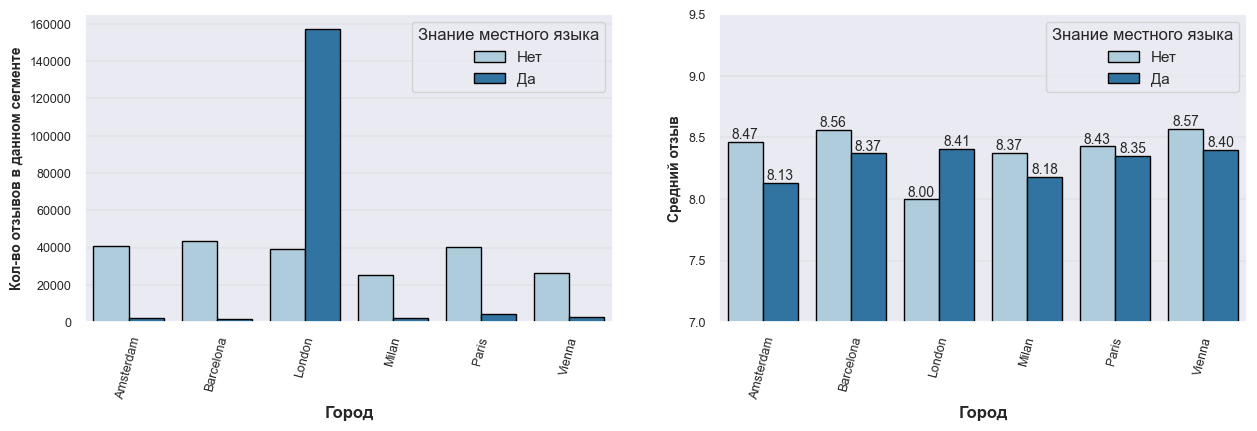

In [597]:
# Построим график по знанию локального языка по местонахождению отеля
reviewer_mother_language = pd.pivot_table(
    data=data[data['sample']==1],
    index=['city','mother_language'], 
    values='reviewer_score', 
    aggfunc=['count', 'mean']).reset_index('mother_language')

reviewer_mother_language.mother_language = reviewer_mother_language.mother_language.apply(lambda x: 'Нет' if x == 0 else 'Да')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), linewidth = .4)

pal2 = sns.color_palette("Paired", 2)
sns.set_palette(pal2)

sns.barplot(x=reviewer_mother_language.index, y=reviewer_mother_language[('count', 'reviewer_score')], hue = reviewer_mother_language.mother_language, ax=ax1);
ax1.set_ylabel('Кол-во отзывов в данном сегменте', fontweight ='bold', fontsize = 10)
ax1.tick_params(axis='x', rotation=75)

bar_rooms = sns.barplot(x=reviewer_mother_language.index, y=reviewer_mother_language[('mean', 'reviewer_score')], hue = reviewer_mother_language.mother_language,ax=ax2);
ax2.set_ylabel('Средний отзыв', fontweight ='bold', fontsize = 10)
ax2.tick_params(axis='x', rotation=75)
plt.ylim(7, 9.5);

for p in bar_rooms.patches:
    bar_rooms.annotate(
    '{:.2f}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()),
    ha='center', va='bottom', fontsize=10)

ax1.set_xlabel('Город', fontweight = 600, fontsize = 12);
ax2.set_xlabel('Город', fontweight = 600, fontsize = 12);

ax1.legend(title = 'Знание местного языка')
ax2.legend(title = 'Знание местного языка')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax2.tick_params(axis='both', which='major', labelsize=9)

Так как основное кол-во отзывов и отелей приходится на Лондон, то и отзывов больше оттуда. Интересный момент - Лондон отличается от всех своих собратьев по обоим графикам. Количество отзывов знающих местный язык, превалирует у Лондона, по сравнению с другими странами. А в разрезе средней оценки, только в Лондоне, знающие местный язык, среднюю оценку поставили выше, в остальных случаях, незнающие местный язык, выставили оценки ниже.

Добавим еще регион и подрегион, чтобы попытаться сделать сегментацию данного признака точнее.

In [598]:
# не все страны можно сопоставить по имени из-за разного описания, поэтому добавим aplha-3 код 
# кодировки из таблицы:
alpha_3_df = pd.read_csv('data\country_regions.csv')
alpha_3 = alpha_3_df[["name", "alpha-3"]].set_index('name').to_dict('dict')['alpha-3']

# закодируем существующие в наших данных страны и создадим из этого словарь
countries_alpha = data['reviewer_nationality'].value_counts().to_frame()
countries_alpha['alpha'] = countries_alpha.index.map(alpha_3)
countries_dict = countries_alpha['alpha'].to_dict()

# датафрейм со странами, присутствующими в наших данных
countries = pd.DataFrame(data.reviewer_nationality.unique(), columns = ['country_name']).set_index('country_name')
countries['alpha'] = countries.index.map(countries_dict)
# добавим недостающие страны
countries.loc['United Kingdom', 'alpha'] = 'GBR'
countries.loc['Russia', 'alpha'] = 'RUS'
countries.loc['Czech Republic', 'alpha'] = 'CZE'
countries.loc['Iran', 'alpha'] = 'IRN'
countries.loc['South Korea', 'alpha'] = 'KOR'
countries.loc['Taiwan', 'alpha'] = 'TWN'
countries.loc['Macedonia', 'alpha'] = 'MKD'
countries.loc['Vietnam', 'alpha'] = 'VNM'
countries.loc['Macau', 'alpha'] = 'MAC'
countries.loc['Moldova', 'alpha'] = 'MDA'
countries.loc['Brunei', 'alpha'] = 'BRN'
countries.loc['Venezuela', 'alpha'] = 'VEN'
countries.loc['Tanzania', 'alpha'] = 'TZA'
countries.loc['Palestinian Territory', 'alpha'] = 'PSE'
countries.loc['Kosovo', 'alpha'] = 'XKX'
countries.loc['Abkhazia Georgia', 'alpha'] = 'GEO'
countries.loc['Cura ao', 'alpha'] = 'CUW'
countries.loc['Syria', 'alpha'] = 'SYR'
countries.loc['Ivory Coast', 'alpha'] = 'CIV'
countries.loc['Bolivia', 'alpha'] = 'BOL'
countries.loc['U S Virgin Islands', 'alpha'] = 'VIR'
countries.loc['British Virgin Islands', 'alpha'] = 'VGB'
countries.loc['Turks Caicos Islands', 'alpha'] = 'TCA'
countries.loc['Antigua Barbuda', 'alpha'] = 'ATG'
countries.loc['St Maarten', 'alpha'] = 'SXM'
countries.loc['Laos', 'alpha'] = 'LAO'
countries.loc['Falkland Islands Malvinas', 'alpha'] = 'FLK'
countries.loc['Crimea', 'alpha'] = 'RUS'
countries.loc['St Pierre and Miquelon', 'alpha'] = 'SPM'
countries.loc['Cocos K I', 'alpha'] = 'CCK'
countries.loc['Swaziland', 'alpha'] = 'SWZ'
countries.loc['Saint Martin', 'alpha'] = 'MAF'
countries.loc['Saint Vincent Grenadines', 'alpha'] = 'VCT'
countries.loc['Reunion', 'alpha'] = 'REU'
countries.loc['Bonaire St Eustatius and Saba', 'alpha'] = 'BES'
countries.loc['Democratic Republic of the Congo', 'alpha'] = 'COD'
countries.loc['East Timor', 'alpha'] = 'TLS'
countries.loc['Svalbard Jan Mayen', 'alpha'] = 'SJM'
countries.loc['Saint Barts', 'alpha'] = 'BLM'
countries.loc['Central Africa Republic', 'alpha'] = 'CAF'
countries.loc['Vatican City', 'alpha'] = 'VAT'
countries.loc['Cape Verde', 'alpha'] = 'CPV'
countries.loc['United States of America', 'alpha'] = 'USA'
countries.loc['Bosnia and Herzegovina', 'alpha'] = 'BIH'

# создаём в данных новый признак
data['alpha'] = data.reviewer_nationality.map(countries.alpha.to_dict())

# создаем датафрейм с полным набором данных для каждой страны
countries_full = countries.merge(alpha_3_df, how = 'inner',\
  left_on='alpha', right_on=['alpha-3'])[['alpha','region','sub-region']]

# двух стран не хватает, добавим вручную
countries_full = pd.concat([countries_full, pd.DataFrame({'alpha' : ['XKX'],'region':['Europe'],'sub-region':['Southern Europe']})],\
  ignore_index = True)
countries_full = pd.concat([countries_full, pd.DataFrame({'alpha' : ['ATA'],'region':['Antarctica'],'sub-region':['Antarctica']})],\
  ignore_index = True)

#итоговый словарь
countries_dict = countries_full.set_index('alpha').to_dict()


In [599]:
# создаем 2 новых признака - регион и подрегион в основном датасете
data['reviewer_region'] = data.alpha.map(countries_dict['region'])
data['reviewer_sub_region'] = data.alpha.map(countries_dict['sub-region'])

In [600]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 52 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

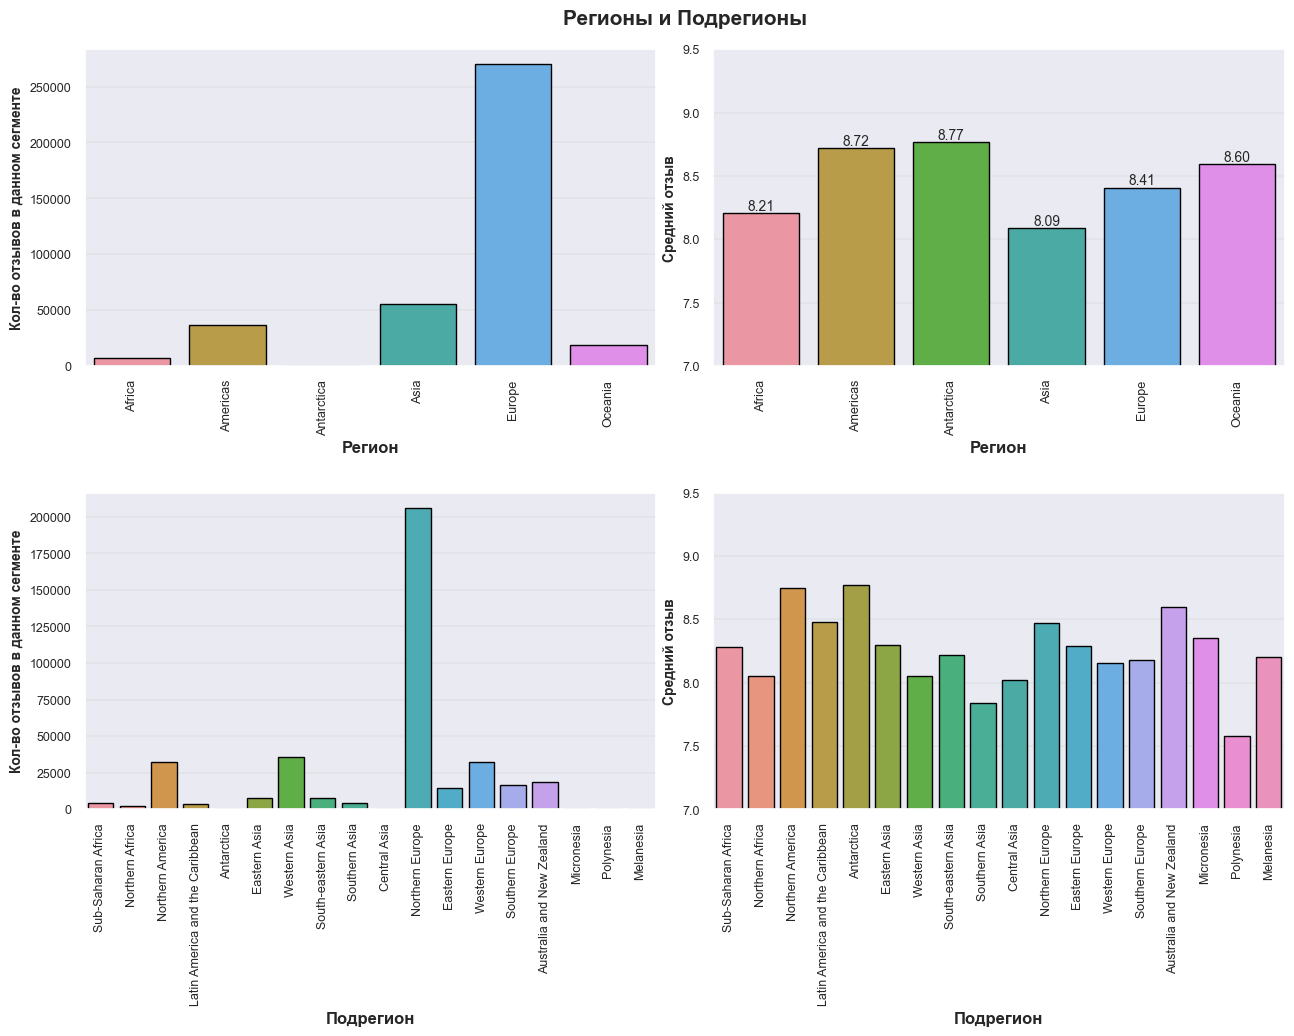

In [601]:
# Построим графики по региону и подрегиону
reviewer_region = pd.pivot_table(
    data=data[data['sample']==1],
    index=['reviewer_region'], 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])

reviewer_sub_region = pd.pivot_table(
    data=data[data['sample']==1].sort_values(by = 'reviewer_region'),
    index=['reviewer_sub_region'], 
    values='reviewer_score', 
    aggfunc=['count', 'mean'],
    sort = False)

fig, (ax1,ax2) = plt.subplots(2, 2, figsize=(15, 4), linewidth = .4)

pal2 = sns.color_palette("Paired", 2)
sns.set_palette(pal2)

sns.barplot(x=reviewer_region.index, y=reviewer_region[('count', 'reviewer_score')],ax=ax1[0]);
ax1[0].set_ylabel('Кол-во отзывов в данном сегменте', fontweight ='bold', fontsize = 10)
ax1[0].tick_params(axis='x', rotation=90)

ax1[1].set_ylim(7, 9.5);
bars = sns.barplot(x=reviewer_region.index, y=reviewer_region[('mean', 'reviewer_score')], ax=ax1[1]);
ax1[1].set_ylabel('Средний отзыв', fontweight ='bold', fontsize = 10)
ax1[1].tick_params(axis='x', rotation=90)

for p in bars.patches:
    bars.annotate(
    '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=10)


plt.suptitle('Регионы и Подрегионы', 
             fontweight ='bold', size=15, y = 2.2)

sns.barplot(x=reviewer_sub_region.index, y=reviewer_sub_region[('count', 'reviewer_score')],ax=ax2[0]);
ax2[0].set_ylabel('Кол-во отзывов в данном сегменте', fontweight ='bold', fontsize = 10)
ax2[0].tick_params(axis='x', rotation=90)

ax2[1].set_ylim(7, 9.5);
sns.barplot(x=reviewer_sub_region.index, y=reviewer_sub_region[('mean', 'reviewer_score')], ax=ax2[1]);
ax2[1].set_ylabel('Средний отзыв', fontweight ='bold', fontsize = 10)
ax2[1].tick_params(axis='x', rotation=90)

plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=2.1,
                    wspace=0.1,
                    hspace=.4)

ax1[0].set_xlabel('Регион', fontweight = 600, fontsize = 12);
ax1[1].set_xlabel('Регион', fontweight = 600, fontsize = 12);
ax2[0].set_xlabel('Подрегион', fontweight = 600, fontsize = 12);
ax2[1].set_xlabel('Подрегион', fontweight = 600, fontsize = 12);

ax1[0].tick_params(axis='both', which='major', labelsize=9)
ax1[1].tick_params(axis='both', which='major', labelsize=9)
ax2[0].tick_params(axis='both', which='major', labelsize=9)
ax2[1].tick_params(axis='both', which='major', labelsize=9)

В итоге мы получили признаки:

* Страна рецензента, мелкие страны обьединены в администартивные ареалы
* Выделили основной/-ые язык(и) путешественника и создали признак, указывающий свободно ли посетитель общается в поездке, или нет 
* Выделили основной регион (материк)
* Выделили подрегион

<a id = '2.5'></a>
## 2.5 Обработка отзывов

Можно заметить, что:

* Не всегда используется английский
* В негативном отзыве может быть позитивный отзыв и наоборот для позитивного отзыва
* Также, может быть просто пробел или запись "No positive"/ "No negative" 
* Негативные фразы, содержащие ограниченное количество слов, библиотекой не могут быть расценены как негативные

In [602]:
# пропущенные заполним словами Neutral, так как далее будем производить семантический анализ текста
data.loc[data[data.negative_review == ' '].index,'negative_review'] = 'Neutral'
data.loc[data[data.positive_review == ' '].index,'positive_review'] = 'Neutral'

In [603]:
sia = SentimentIntensityAnalyzer()

def get_scores(review):
    """Функция принимает на вход отзыв и производит оценку семантики, 
    возвращает её в числовом виде для последующего анализа
    Args:
        review text (str): строка, содержащая отзыв
    Returns:
        series 
    """ 
    sia_scores = sia.polarity_scores(review) # sentiment intensity analyzer
    return pd.Series({
        'review' : review,
        'negative' : sia_scores['neg'],
        'neutral'  : sia_scores['neu'],
        'positive' : sia_scores['pos'],
        'compound' : sia_scores['compound']
    })

In [604]:
# Уберем пробелы с обоих концов отзывов и приведем к одному уровню
data.negative_review = data.negative_review.apply(lambda x : x.strip().capitalize())
data.positive_review = data.positive_review.apply(lambda x : x.strip().capitalize())

# создадим отдельный датасет с уникальными негативными отзывами с количеством слов менее 8 
review_symbols_neg_df = data[(data.negative_review.notna()) & (data.review_total_negative_word_counts < 8)].negative_review.value_counts().to_frame()

In [605]:
review_symbols_neg_df

,count
negative_review,
No negative,127890
Nothing,21185
N a,1815
None,1501
Neutral,849
...,...
Parking parking and parking,1
Location is a bit far out,1
Noisy corridors,1


In [606]:
# Выберем часть негативных отзывов из датасета, которые имеют менее 8 слов
review_symbols_neg = data[(data.negative_review.notna()) & (data.review_total_negative_word_counts < 8)].negative_review
review_symbols_neg_df_tmp = review_symbols_neg[10:30].drop(columns='index')
# Посмотрим, как негативные отзывы оценены системой
review_symbols_neg_df_sent = review_symbols_neg_df_tmp.apply(get_scores)
display(review_symbols_neg_df_sent)

,review,negative,neutral,positive,compound
15,No negative,1.000,0.000,0.000,-0.7096
16,Nothing hotel refurb great,0.523,0.477,0.000,-0.5096
17,Nothing,0.000,1.000,0.000,0.0000
25,Bar,0.000,1.000,0.000,0.0000
26,No negative,1.000,0.000,0.000,-0.7096
31,No negative,1.000,0.000,0.000,-0.7096
32,No negative,1.000,0.000,0.000,-0.7096
34,No real bar,0.524,0.476,0.000,-0.2960
36,Nothing this hotel has everything,0.000,1.000,0.000,0.0000
37,Nothing,0.000,1.000,0.000,0.0000


Можем видеть, что:

* "All" несет смысл что плохо всё, а мы оцениваем его нейтрально
* также - "Bar"
* "No negative" несет в себе смысл, что ничего плохого, а оценка негативности дает -1, и общий балл (compound) становится отрицательным

Напишем regular expressions, которые в коротких отзывах вылавливают явно позитивные отзывы, и заменяют их на нейтральную фразу, которая будет воспринята корректнее семантической библиотекой.

Также введем дополнительный признак, где отмечается, отзыв отрицательный или положительный.
Все что попало под правила regular expression - несло в себе положительный отзыв, остальное  - отрицательный.

In [607]:
# отлов позитивных, и местами явно негативных отзывов (есть негативные, которые опознаются как позитивные), с последующей заменой 
repl_ind = review_symbols_neg_df[review_symbols_neg_df.index.str.contains('excel|positiv', regex=True, case=False)].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?!(?<=not.)|(?<=4.))(100|was perfect)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?<!not.)(ama?zi)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('\sfab', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?!(?<=not.)|(?<=wasn.t.)|(?<=not.very.))nice', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?<!too much.)(no comme|no recom|to ment)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('Nothing to com|no bad co', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?!(?<=not a.)|(?<=phonique.)|(?<=is not.)|(?<=not.))perfect', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('cou.+t.+f.+nd', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('((will.)|(w[a|e][s|r].?n?(\s?)t.)|(i\w+(\s?)t.)|(not?(\s?))|(not?(\s?)(v[a|e]ry|so|a|that|really|too|such|the)\s))t?h?[a|e]?t?.?(good|great)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 1
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('would.+(?<!not.)(recom|happi|retur|stay|defin)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(great|good).+but', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 1
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('lack', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 1
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?!(?<=nothing.)|(?<=wasnt the.)|(?<=not the.)|(?<=not always.))(great|good)(?!.be better)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('nothing.(great|good)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('not?\sthe\sbest', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 1
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('nothing.(except|well)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 1
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('^N A|^Noth', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('^Notti|^nil|^nul', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('^none', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('^(\w){1,2}$', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('^nope.?|^nowt$|^zero$|(zero\s(disl|compl|faul|issu|noth|love|all w|no and))', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('I (?:(?!dont.)|(?:just.)|(?:do.))like.(?!.nothing)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('dislike', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('like(.)+(ev|it a|al)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('w?a?s?\s?liked (most|loc|break)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('generally (i li|satis|ok)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('absolutely loved|i love|loved? ever|(?<!hard.)lovely|love[s|d] (it|our|all|the who|this|the hotel)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?<!expensive.)enjoyed|enjoyable', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?:(simply\s?|honest\s?|totally\s?|no\s?|in fact\s?|think\s?|guess\s?|mm\s?|Absurdity\s?|almost\s?|fault\s?|basic(.)+|as such\s?|A?o?s.l.te?ly\s?|about\s?|actually\s?|also\s?|Completely\s?|Disadvantages\s?|er\s?|em\s?|personally\s?|for us\s?|found\s?|franky\s?|just\s?|really\s?|honestly\s?))nothing(?!.around|.more)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?:(particular\s?|literally\s?|well\s?|truly\s?|so far\s|that is\s?|was\s?|there is\s?|pretty much\s?|reall?y\s?|rien\s?|seriously\s?|nearly\s?|maybe\s?|honesty\s?|simply\s?|Practically\s?|overall\s?))nothing', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?<!location absolutely.)nothing (?:(around|special|important|to say|bad|against|too special))', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?:(at the moment\s?|frankly\s?|from our stay\s?|d say\s?|speechless\s?|my case\s?|change\s?|occasion\s?|One sentence\s?|Silly question\s?))nothing', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?<!prices.)(all a?r?e?\s?fine|^all g[i|o|u]|fantas|all excemp)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('best(?!\s?was\s?unco)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('was (?:(ok|fine|well|first cl|all rig|outst|very sat|really fin))', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('all ok|no issue|no negat|no fault', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('all\s.+accept|superb', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('honestly|rything was super', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('^not really anythi|^not really$|^not really at', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('no compla|happy|no proble|nada|(?<!not.)brill|(?:(was.|all.))cool|(?<!not.)as expect|wonder', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('couldn.?t\s? (be bet|faul|comp|reall|name|pick)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?!(?<=only.)|(?<=ignoring a.))compla', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(all|everything) (accept|cool|correct|in gene|is bett|is wel|excemp|in all|ok)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('leave|faultles|all reasona|(^all|\sall)(.)+well', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('can\s?.?.?t (find|remem|tell|thin|real|say|compl|imagine bet|faul|report|stay he)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('did\s?.?.?t (have one|use|find any|have anyt|find|notice an)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(doesn\'?t|don\s?t)\s(have (any|conc)|know|have$|think|remem|appl)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('things?\s?(is|was|)\s?(ok|fine|well|just bril|grat|allr)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('things?\s?(is|was|)\s?(o\s?k|fine|well|just bril|grat|allr|accep|awes|adeq|1st|10 p|beyo|compl|cool|deligh|exel|five|impecc|just (help|ok|sens)|perfe|w[o|u]nd|super|suita|specta|splend|t?o? (expec|satisf))', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('thing (went|we|was) (fine|right|top|very ple)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('had to go|had to come|had to end', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('have non?e? (sugg|crit|obj)|have none|heading hom', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('to none|not much (at all|needs|rea|to chan)|hmm', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('(?!(?<=opening)|(?<=my stay)|(?<=should stayed)|(?<=should stay)) longer(?! break| stay| bed)', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('fault(?!y)|to say|no improvemen|no not|no partic|no probl|no probs|no quest|no real (issu|negat)|no rema|no regre|no specif|no suggest|no though|not mut?ch (x|to crit|to impro)|not sure$|noting|only stay|pretty (fancy|satis|much)|super locat|alles super|^very clean|vse|we were|zilch', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_neg_df[(review_symbols_neg_df.index.str.contains('no adv.+comments|(highly|ally) recomm', regex=True, case=False))].index
review_symbols_neg_df.loc[repl_ind,'translate'] = 0

In [608]:
# создаем словарь всех замен
review_symbols_neg_all_dict = review_symbols_neg_df.to_dict('dict')
# создаем словарь замен только нейтральных отзывов в негатвиных отзывах
review_symbols_neg_Zero_dict = review_symbols_neg_df[review_symbols_neg_df.translate == 0].to_dict('dict')
# создаем новый признак и отмечаем нейтральные отзывы
data['corr_negative_index'] = data.negative_review.map(review_symbols_neg_all_dict['translate'])
# все что не нейтральное, определяем как негативное
data.loc[data[data['corr_negative_index'].isna()].index,'corr_negative_index'] = 1

In [609]:
# Создаем новый признак "скорректированный негативный отзыв", где нейтральные отзывы заменяем словами Neutral
# Остальные оставляем как были
data.loc[data[data.negative_review.isin(review_symbols_neg_Zero_dict['translate'])].index,'neg_review_corrected'] = \
  data[data.negative_review.isin(review_symbols_neg_Zero_dict['translate'])].negative_review.map(review_symbols_neg_Zero_dict['translate'])

data.loc[data[data['neg_review_corrected'].notna()].index,'neg_review_corrected'] = 'Neutral'
data.loc[data[data['neg_review_corrected'].isna()].index,'neg_review_corrected'] = data[data['neg_review_corrected'].isna()].negative_review.map(lambda x : x)

In [610]:
# делаем всё аналогично для позитивных отзывов
review_symbols_pos = data[(data.positive_review.notna()) & (data.review_total_positive_word_counts < 8)].positive_review
review_symbols_pos_df = review_symbols_pos.value_counts().to_frame()
review_symbols_pos_df.translate = np.nan

repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('only.+stay', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 1
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('only', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('(was|is) no?t bad', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 1
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('(was|is) bad', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('^bad (exp|break|atti|show|and old|conn|not|cust|sta|pill)', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('(?<!Nothing to say) very bad', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('(?<!Nothing to say) very bad', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('bad exp|^bad$|really bad|very bad', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('noth', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('awful', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('don\s?t li', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('no pos', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('dirty|smelly|terrib|overpric|worst', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('crampe|noisy|uncom|rude|poor|horrib|ennorm|outdate|not? mu.h|not great|not includ|not clean|not a lot|none|no thi|no like|disli', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('no (elev|faci|info|heat|good|inter|like|no |need to re|rest|smok|tha|real)', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('no (reply|tv|use|non)', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('not (comin|as goo|cosy|enough|good)', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0
repl_ind = review_symbols_pos_df[review_symbols_pos_df.index.str.contains('zero|nil$|nul|nith', regex=True, case=False)].index
review_symbols_pos_df.loc[repl_ind,'translate'] = 0

In [611]:
review_symbols_pos_df

,count,translate
positive_review,,
No positive,35946,0.0
Location,11945,NaN
Everything,3314,NaN
Nothing,1731,0.0
Great location,1687,NaN
...,...,...
Design and atmosphere really nice,1,NaN
So clean and pretty,1,NaN
Cosy great location clean,1,NaN


In [612]:
review_symbols_pos_all_dict = review_symbols_pos_df.to_dict('dict')
review_symbols_pos_Zero_dict = review_symbols_pos_df[review_symbols_pos_df['translate'] == 0].to_dict('dict')
data['corr_positive_index'] = data.positive_review.map(review_symbols_pos_all_dict['translate'])
data.loc[data[data['corr_positive_index'].isna()].index,'corr_positive_index'] = 1

data.loc[data[data.positive_review.isin(review_symbols_pos_all_dict['translate'])].index,'pos_review_corrected'] = \
  data[data.positive_review.isin(review_symbols_pos_all_dict['translate'])].positive_review.map(review_symbols_pos_all_dict['translate'])
  
data.loc[data[(data['pos_review_corrected'].notna()) & (data.corr_positive_index == 0)].index,'pos_review_corrected'] = 'Negative'
data.loc[data[(data['pos_review_corrected'].notna()) & (data.corr_positive_index == 1)].index,'pos_review_corrected'] = 'Positive'
data.loc[data[data['pos_review_corrected'].isna()].index,'pos_review_corrected'] = data[data['pos_review_corrected'].isna()].positive_review.map(lambda x : x)

In [613]:
data.neg_review_corrected.replace({'Nothing': 'Neutral','N a' : 'Neutral', 'None' : 'Neutral', 'Nil' : 'Neutral', 'Na' : 'Neutral', 'No' : 'Neutral',\
  'Nothing at all' : 'Neutral', 'Nothing really' : 'Neutral', 'Nothing not to like' : 'Neutral', 'Non' : 'Neutral', 'Not applicable' : 'Neutral', 'Nothing in particular' : 'Neutral',\
  'There was nothing i didn t like' : 'Neutral', 'Nothing comes to mind' : 'Neutral', 'Not a thing':'Neutral',
  'No thing' : 'Neutral','No bad experience' : 'Neutral','No bad experiences' : 'Neutral',
  }, inplace = True)
data.pos_review_corrected.replace({'No positive': 'Neutral'}, inplace = True)

# Скорректируем указатель на явно не негативный отзыв, после последних коррекций
data.loc[data[data['neg_review_corrected'] == 'Neutral'].index,'corr_negative_index'] = 0

In [614]:
# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

data['neg_scores'] = data['neg_review_corrected'].apply(lambda x: sia_neg.polarity_scores(x))
data['pos_scores'] = data['pos_review_corrected'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
data['n_review_sentiments_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['pos_scores'].apply(lambda x: x['compound'])

<a id = '3'></a>
# 3. Отбор признаков

In [615]:
# посмотрим, какие признаки были созданы в итоге:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 66 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

Избавимся от ненужных признаков, которые не подходят для машинного обучения (такие как строки, даты). 
Сделаем анализ на наличие мультиколинеарности.

In [616]:
# создаем дубликат базы для дальнейших манипуляций со столбцами (для обратимости экспериментов):
data_copy = data.copy()

In [617]:
# посмотрим признаки типов категория, дата и строки
def getNonNumberTypeFeatures(df):
    """Функция возвращает в списке все признаки из датасета, что подходят под описанные правила

    Args:
        df (pandas.Dataframe()): Датасет

    Returns:
        list: Список признаков
    """
    object_columns = [s for s in data_copy.columns
                    if ((data_copy[s].dtypes == 'object') | \
                        (data_copy[s].dtype.name == 'category') | \
                        (data_copy[s].dtypes == 'datetime64[ns]') |
                        (data_copy[s].dtype.name == 'period[M]'))]
    return object_columns

types_list = getNonNumberTypeFeatures(data_copy)
print("Количество признаков, которые надо удалить,\
 либо привести к машиноподходящему типу:", types_list.__len__())
display(types_list)

Количество признаков, которые надо удалить, либо привести к машиноподходящему типу: 27


['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review',
 'lat',
 'lng',
 'city',
 'country',
 'post_index',
 'review_period',
 'trip_type',
 'travellers_type',
 'room_class',
 'reviewer_languages',
 'hotel_country_language',
 'review_region',
 'alpha',
 'reviewer_region',
 'reviewer_sub_region',
 'neg_review_corrected',
 'pos_review_corrected',
 'neg_scores',
 'pos_scores']

In [618]:
# Удалим признаки, которые не будем дальше использовать
drop_list = []

drop_list.append('hotel_name')
drop_list.append('review_date')
drop_list.append('negative_review')
drop_list.append('positive_review')
drop_list.append('temp_tag_count')
drop_list.append('tags')
drop_list.append('lat')
drop_list.append('lng')
drop_list.append('review_period')
drop_list.append('alpha')
drop_list.append('neg_review_corrected')
drop_list.append('pos_review_corrected')
drop_list.append('neg_scores')
drop_list.append('pos_scores')

data_copy.drop(drop_list, axis = 1, inplace=True)

# Перекодируем нужные нам признаки в категорийный тип с последующим порядковым кодированием, 
# (те что не удалили, а признали полезными).

for feature in getNonNumberTypeFeatures(data_copy):
  data_copy[feature] = data_copy[feature].astype('category')
  data_copy[feature] = data_copy[feature].cat.codes


In [619]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 52 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  int16  
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   reviewer_nationality                        515738 non-null  int16  
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   days_since_review                           515738 non-null  int16  
 

In [620]:
# Признаков много из разных областей, поэтому поделим их на смысловые и типовые группы
# Непрерывные и категориальные признаки:
num_cols = [
    # признаки, связанные с количеством слов:
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    
    # признаки, связанные с анализом эмоциональной окраски отзывов:
    'n_review_sentiments_neg', 'n_review_sentiments_neu',
    'n_review_sentiments_pos', 'n_review_sentiments_compound',
    'p_review_sentiments_neg', 'p_review_sentiments_neu',
    'p_review_sentiments_pos', 'p_review_sentiments_compound',  

    # остальные количественные:
    'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',
    'distance_from_center'
]

cat_cols = [
    # характеристики отеля
    'average_score', 'additional_number_of_scoring', 'total_number_of_reviews',
    'hotel_address', 'city', 'country', 
    'post_index',  'days_since_review',

    # характеристики поездки (номер):
    'trip_type', 'sumbit_type','travellers_type','with_pet_type','with_view',
    'without_window','room_class','count_nights','Couple','Stayed 2 nights', 
    'Leisure trip','Group','Solo traveler','Stayed 1 night','Business trip',
    'Submitted from a mobile device','Family with young children','Stayed 3 nights',

    # характеристики рецензента:
    'review_region','reviewer_languages', 'reviewer_nationality',
    'hotel_country_language','mother_language','reviewer_region','reviewer_sub_region',

    # время поездки:
    'month', 'year', 'day',

    # характеристики отзыва:
    'corr_negative_index', 'corr_positive_index',
]

In [621]:
# Обернем построение корреляционной диаграммы в функцию
def show_corr_heatmap(columns_list, title, method):
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = data_copy[columns_list].corr(method=method).abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True,
                annot_kws={"fontsize":9}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='GnBu',
                fmt='.2f')
    ax_.set_title(title, fontsize=18)
    plt.show()

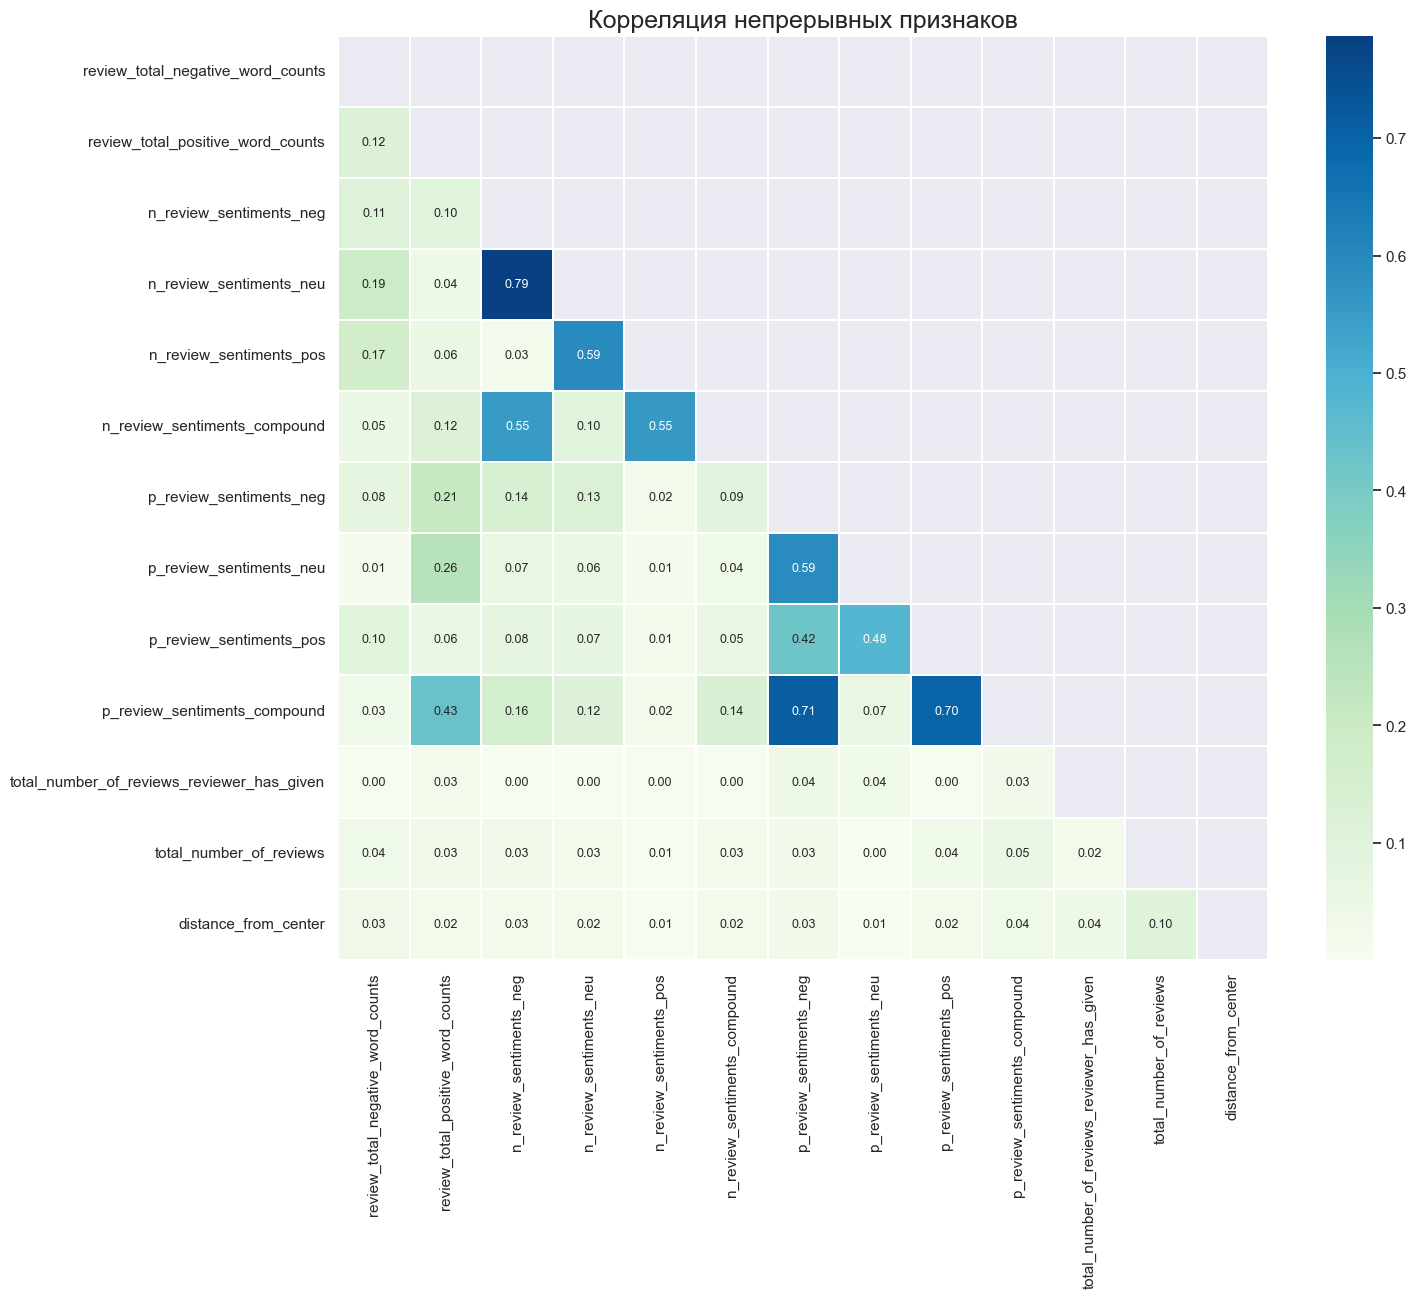

In [622]:
# строим диаграмму для непрерывных признаков:
show_corr_heatmap(num_cols, 'Корреляция непрерывных признаков', method='pearson');

In [623]:
# чтобы вывести в "копируемом" формате, напишем следующие строки кода:
corr = data_copy[num_cols].corr(method='pearson')
print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()

corr_unstack = corr_unstack.rename(columns = {'level_0' : 'feature 1', 'level_1' : 'feature 2',0 : 'Corr ind' }).\
     sort_values(by = 'Corr ind', ascending = False)
corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr ind'] > .7))].\
  iloc[0::2,:].reset_index(drop = True)

Наиболее высокая корреляция между признаками:


,feature 1,feature 2,Corr ind
0,n_review_sentiments_neg,n_review_sentiments_neu,0.787286
1,p_review_sentiments_compound,p_review_sentiments_neg,0.710621
2,p_review_sentiments_compound,p_review_sentiments_pos,0.700640


Есть высококореллируемые признаки, но все они относятся к оценке сентиментов, и в данном случае они корректируют друг друга, и тут их лучше оставить.

In [624]:
# поделим признаки на 2 раздела
segment_1 = cat_cols[:10] + cat_cols[28:]
segment_2 = cat_cols[10:28]

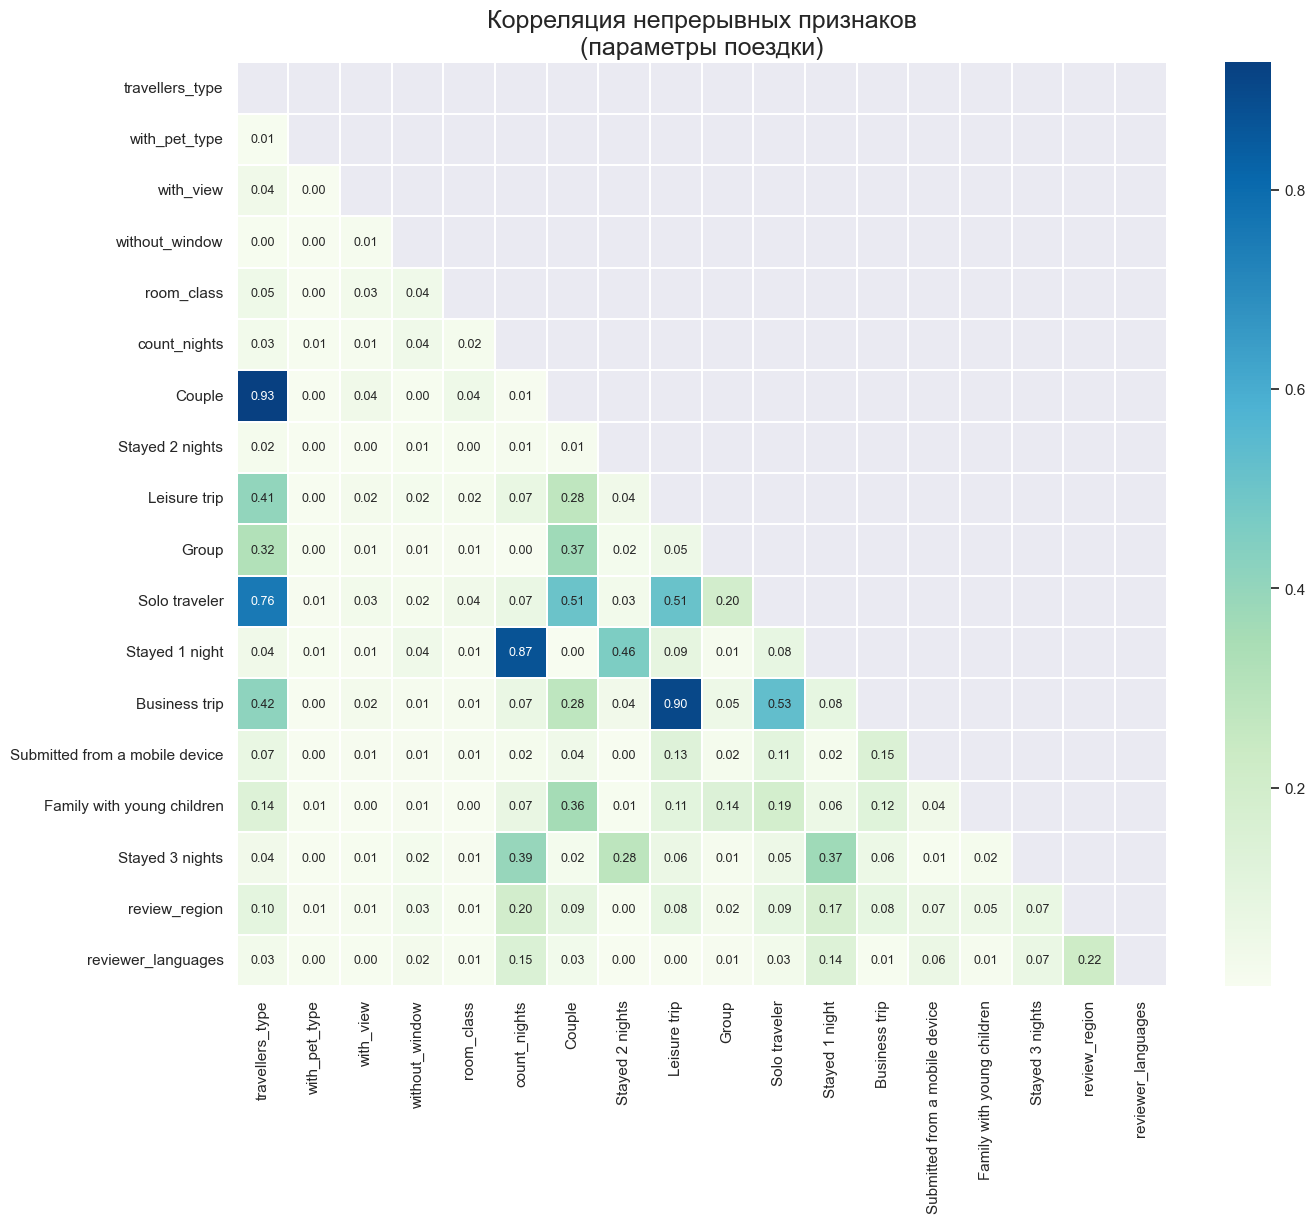

In [625]:
show_corr_heatmap(
    segment_2, 
    'Корреляция непрерывных признаков\n(параметры поездки)', 
    method='spearman'
);

In [626]:
drop_columns = []
drop_columns.append('Submitted from a mobile device')
drop_columns.append('trip_type')
drop_columns.append('count_nights')
drop_columns.append('travellers_type')

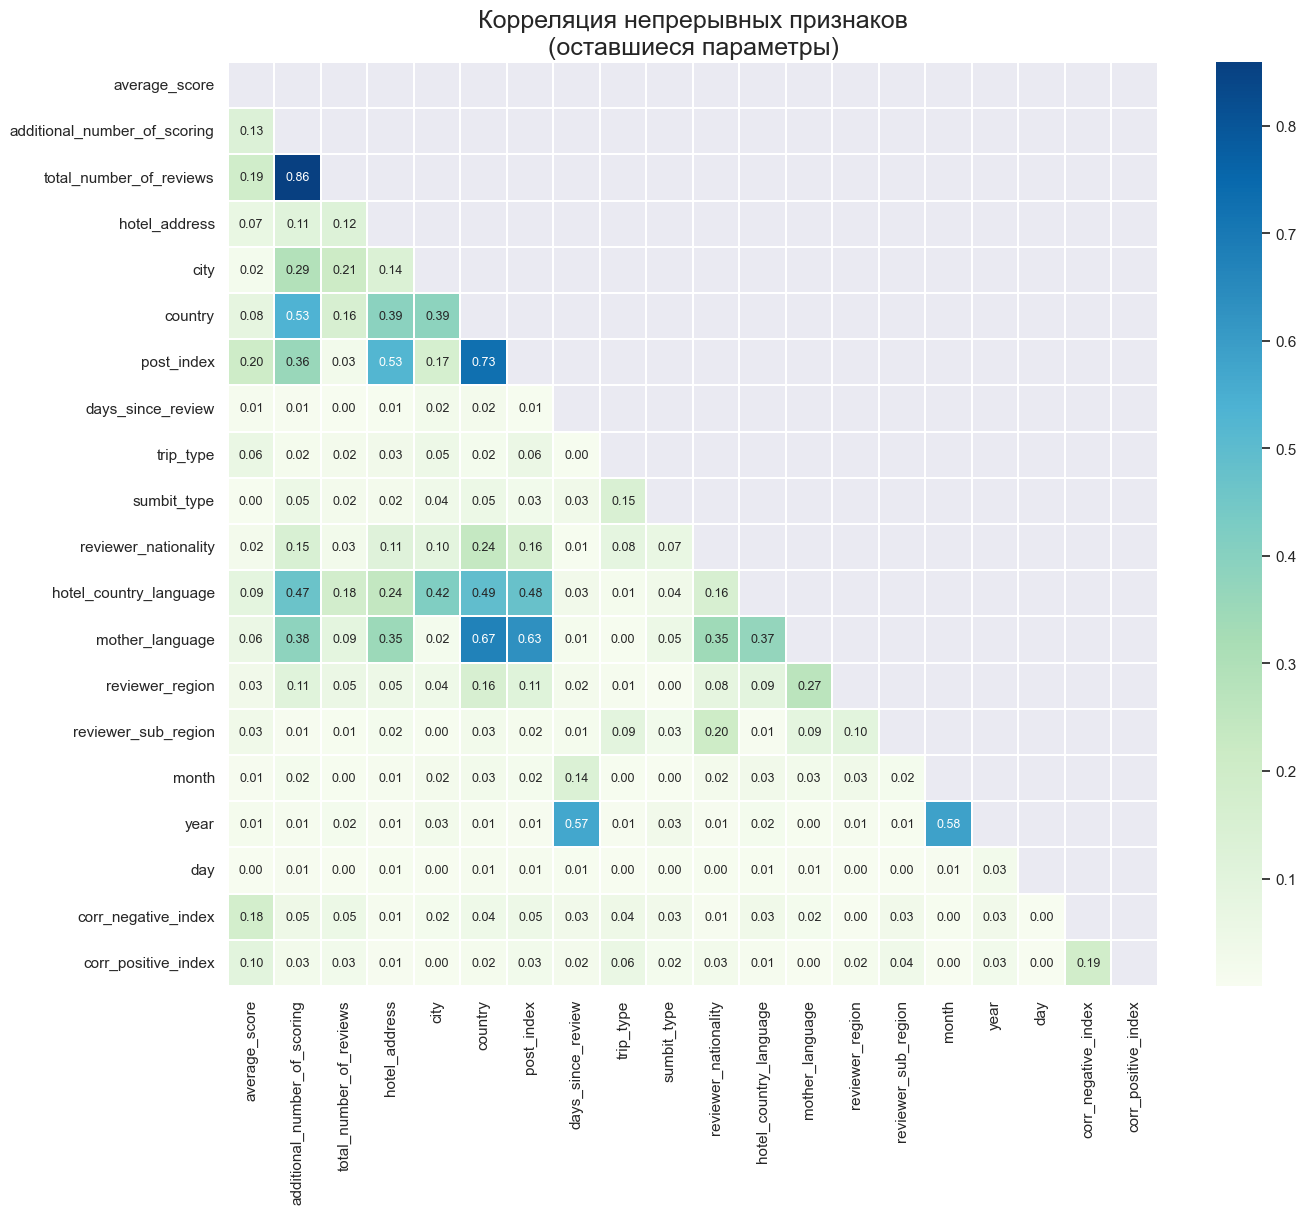

In [627]:
show_corr_heatmap(
    segment_1, 
    'Корреляция непрерывных признаков\n(оставшиеся параметры)',  
    method='spearman'
);

In [628]:
# данный признак высококореллируемый и должен быть удален
drop_columns.append('additional_number_of_scoring')

Проведем оценку значимости признаков. Воспользуемся для оценки дисперсионным анализом ANOVA:

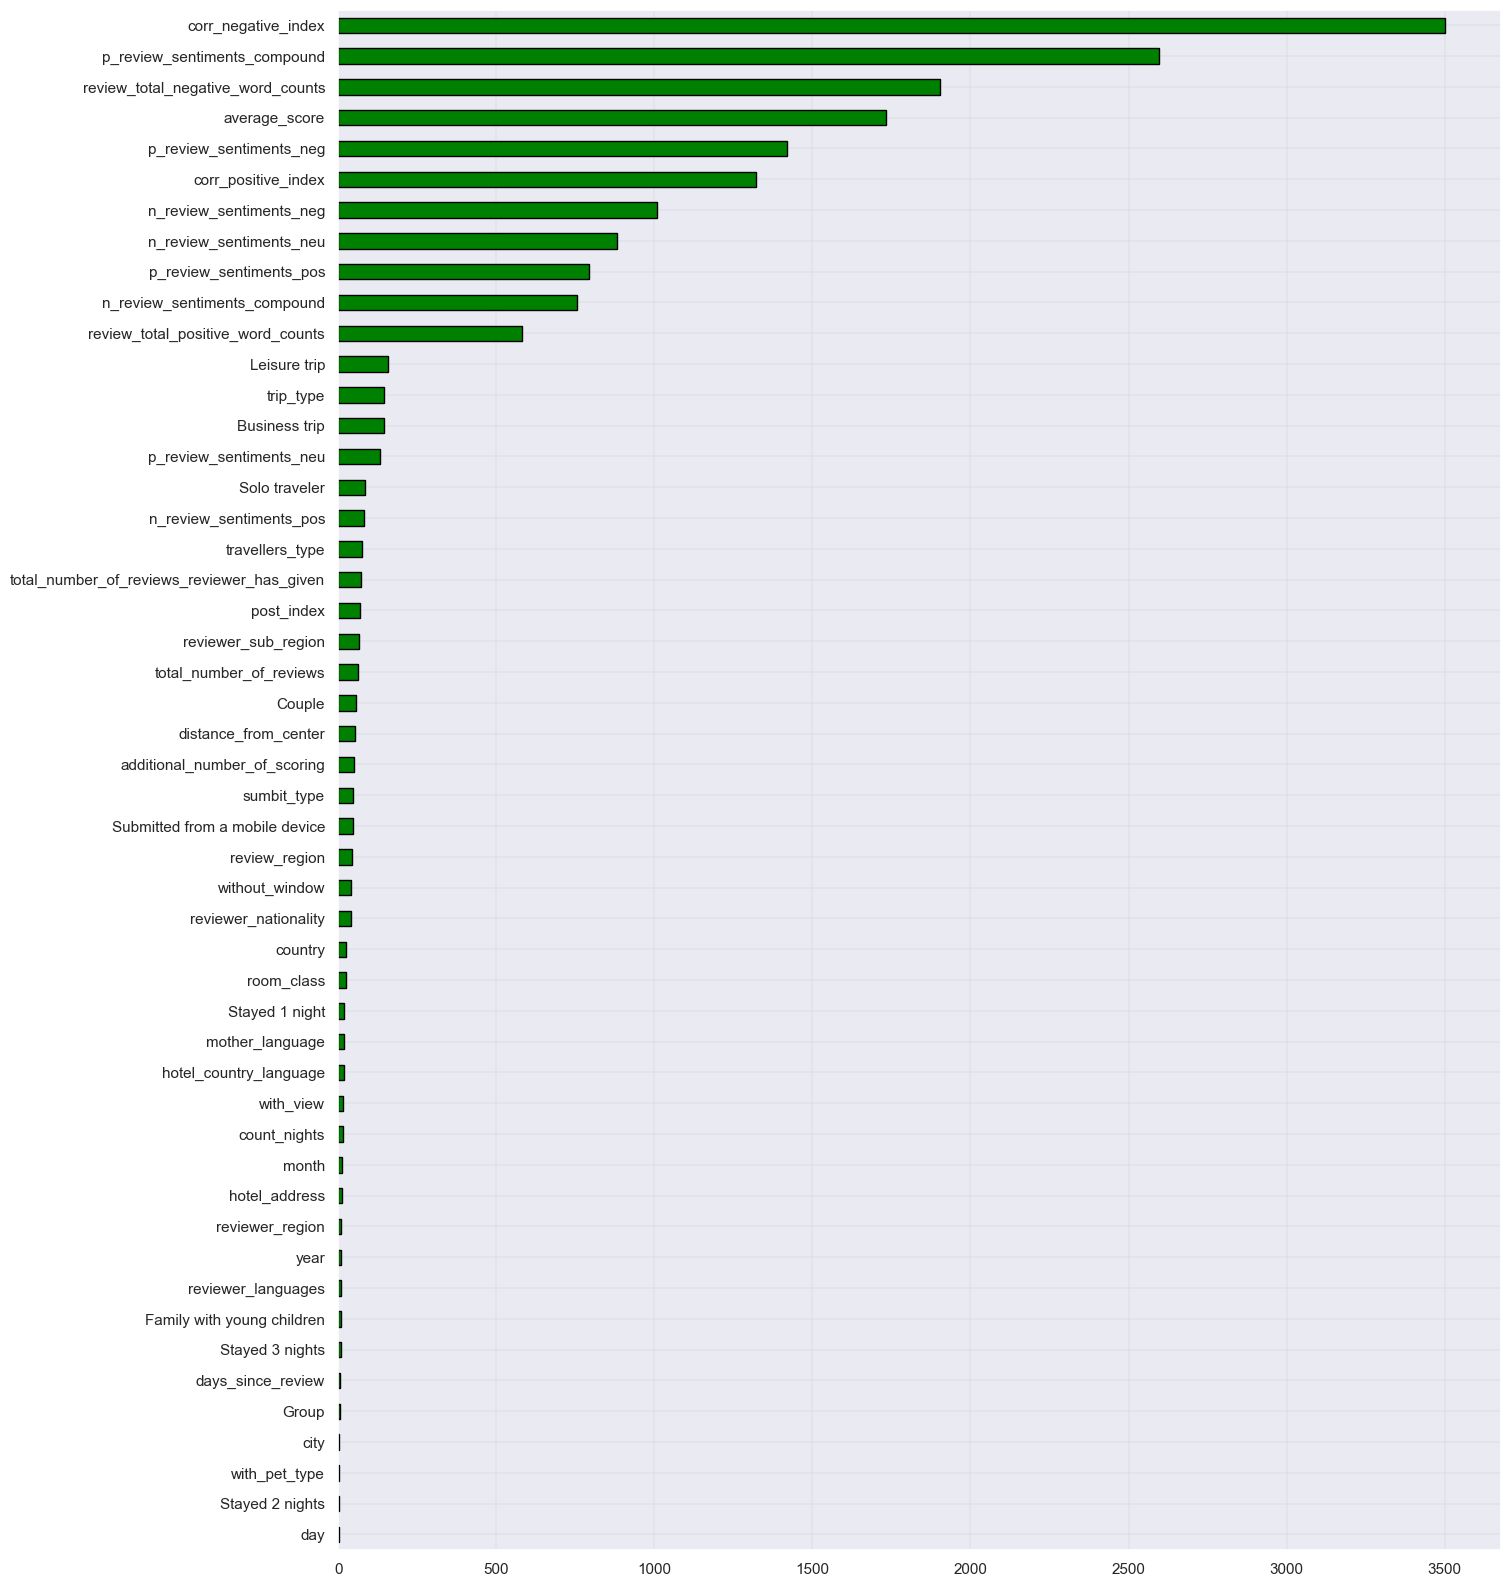

In [629]:
y = data_copy.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data_copy.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

У нас есть несколько признаков в самой нижней части графика, которые почти не обладают "значимостью". Добавим их к списку на удаление.

In [630]:
drop_columns.extend(['days_since_review', 'Group', 
                'city', 'with_pet_type', 'Stayed 2 nights', 'day','Stayed 3 nights',
                'Family with young children','reviewer_languages'])

In [631]:
drop_columns

['Submitted from a mobile device',
 'trip_type',
 'count_nights',
 'travellers_type',
 'additional_number_of_scoring',
 'days_since_review',
 'Group',
 'city',
 'with_pet_type',
 'Stayed 2 nights',
 'day',
 'Stayed 3 nights',
 'Family with young children',
 'reviewer_languages']

In [632]:
# удалим незначимые числовые данные:
print(f'Удалим еще {len(drop_columns)} столбцов с числовыми данными')
data_copy.drop(drop_columns, axis = 1, inplace=True)

print(f'Итоговое получившееся количество признаков: {len(data_copy.columns)}')
print('(включая столбец "Sample" и целевой столбец)')

Удалим еще 14 столбцов с числовыми данными
Итоговое получившееся количество признаков: 38
(включая столбец "Sample" и целевой столбец)


<a id = '4'></a>
# 4. Обучение моделей и получение предсказаний

In [633]:
# В самом начале мы не удалили дубликаты, но они есть:
train_data = data_copy.query('sample == 1').drop(['sample'], axis=1).drop_duplicates()
test_data = data_copy.query('sample == 0').drop(['sample', 'reviewer_score'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

# воспользуемся специальной функцией train_test_split для разделения тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE)

# проверяем размеры:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 36), (386476, 37), (386476, 36), (309180, 36), (77296, 36))

## Алгоритм - RandomForestRegressor

In [634]:
model = RandomForestRegressor(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1, 
    random_state=RANDOM_STATE)

In [635]:
%%time

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s


CPU times: total: 36min 9s
Wall time: 12min 39s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.9s finished


In [636]:
random_forest = round(metrics.mean_absolute_percentage_error(y_test, y_pred) * 100, 4)
print('Результат MAPE:', random_forest)

Результат MAPE: 12.1554


In [637]:
# предсказываем оценки:
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.2s finished


* Оценки не могут быть выше 10, поэтому все записи, где предсказано выше 10-ти, приводим к 10-ти
* Аналогично и для минимальной оценки. Минимальная встречаемая была 2.5, сделаем это нижним порогом по аналогии с предыдущим пунктом
* Округляем до 0,1

In [638]:
sample_submission['reviewer_score'] = sample_submission['reviewer_score'].apply(lambda x : 10 if x > 10 else x)
sample_submission['reviewer_score'] = sample_submission['reviewer_score'].apply(lambda x : 2.5 if x < 2.5 else x)
sample_submission['reviewer_score'] = sample_submission['reviewer_score'].apply(lambda x : round(x,1))

# сохраняем результат:
sample_submission.to_csv('submission.csv', index=False)